<a href="https://colab.research.google.com/github/Shree-Mh/Project/blob/main/ansi2025/ANAIS_2025_Lab_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical LLM Fine-Tuning Tutorial

<img src="https://sbilab.iiitd.edu.in/img/logo_new.png" alt="SBILab Logo" width="100">
<img src="https://www.iiitd.ac.in/sites/default/files/images/logo/style3colorlarge.png" alt="IIIT Delhi Logo" height="100">

## By Jivitesh Sabharwal, PhD Scholar at IIIT Delhi
Guided by **Prof. Anubha Gupta**


## Objective of the Tutorial

The primary objective of this tutorial is to provide a **hands-on, end-to-end understanding of fine-tuning small and medium-sized language models (SLMs/LLMs)** for **medical question answering tasks** using **parameter-efficient adaptation techniques**.

By the end of this notebook, participants will:
- Understand how domain-specific data differs from general-purpose language data
- Learn how to adapt a pretrained language model to the medical domain using **LoRA and adapter-based fine-tuning**
- Gain practical experience in preparing medical datasets for instruction-style training
- Evaluate and interpret performance differences between a base model and a fine-tuned model

The tutorial is designed to be **practical, reproducible, and runnable on limited GPU resources**, such as Google Colab.



## Datasets Used

We will work with two widely used medical QA benchmarks that reflect different reasoning styles:

- **PubMedQA**  
  - Yes / No / Maybe questions derived from PubMed abstracts  
  - Focuses on biomedical literature understanding and reasoning  

- **MedMCQA**  
  - Multiple-choice questions sourced from medical entrance examinations  
  - Tests clinical knowledge, factual recall, and reasoning  

Using both datasets allows us to demonstrate fine-tuning for **binary-style reasoning** as well as **multi-choice clinical decision-making**.



## What This Tutorial Covers

This notebook walks through the **complete fine-tuning pipeline**, including:

1. **Data Exploration**  
   - Inspecting dataset structure  
   - Understanding label formats and question styles  

2. **Data Preparation**  
   - Converting raw QA data into instruction-following prompts  
   - Designing input–output templates suitable for LLM training  

3. **Model Fine-Tuning**  
   - Applying **4-bit Quantization** using *BitsAndBytes*.
   - Applying **LoRA (Low-Rank Adaptation)** to reduce trainable parameters  
   - Fine-tuning without updating the full model weights  

4. **Evaluation and Analysis**  
   - Comparing base model vs fine-tuned model accuracy  
   - Understanding when and why fine-tuning helps  
   - Identifying common pitfalls in evaluation  

Throughout the tutorial, emphasis is placed on **conceptual clarity**, **engineering best practices**, and **debugging common issues** encountered during fine-tuning.



## Target Audience

This tutorial is intended for:

- Graduate students and researchers who want to get into **AI, ML**
- Practitioners interested in **domain adaptation of LLMs**
- Participants with basic familiarity with:
  - Python and PyTorch
  - Hugging Face Transformers
  - Fundamental NLP concepts  

No prior experience with LoRA or adapter-based fine-tuning is assumed.



## Why Parameter-Efficient Fine-Tuning?

Medical and scientific datasets pose unique challenges for training large language models. In practice, these datasets are often:

- **Small in size** compared to general web-scale corpora, increasing the risk of overfitting
- **Sensitive and expensive to curate**, limiting opportunities for large-scale supervised training
- **Trained under constrained compute environments**, such as a single consumer-grade GPU such as **Nvidia RTX Series GPUs** or cloud notebooks like **Google Colab**.

Under these constraints, **full fine-tuning of all model parameters is often impractical or unnecessary**.



### Limitations of Full Fine-Tuning

Standard full-model fine-tuning requires:
- Updating **billions of parameters**
- Storing **optimizer states and gradients** for every parameter
- Large GPU memory for activations, gradients, and optimizer buffers

This leads to:
- High VRAM consumption
- Longer training times
- Frequent out-of-memory (OOM) errors on limited hardware
- Increased risk of catastrophic forgetting, where the model loses its general-language capabilities

As a result, full fine-tuning is often infeasible on GPUs with limited memory, such as those available in Google Colab or institutional shared clusters.



### Advantages of Parameter-Efficient Fine-Tuning (PEFT)

Parameter-efficient fine-tuning methods, such as **LoRA (Low-Rank Adaptation)**, address these issues by:

- **Freezing the pretrained model weights** and training only a small number of additional parameters
- Introducing **low-rank update matrices** that capture task-specific adaptations
- Reducing the number of trainable parameters by several orders of magnitude

This results in:
- Dramatically lower GPU memory usage
- Faster training and iteration cycles
- The ability to fine-tune larger models on modest hardware
- Improved training stability on small datasets

In many cases, less than **1–5% of the total parameters** are updated, while achieving performance close to full fine-tuning.



### Why PEFT Works Well for Low-Resource GPUs

From a systems perspective, PEFT reduces resource requirements by:

- Eliminating gradient computation for frozen parameters
- Reducing optimizer state memory (for example, Adam states are stored only for adapter parameters)
- Lowering communication overhead in distributed or multi-GPU settings
- Allowing higher batch sizes or longer sequence lengths within the same memory budget

This makes PEFT especially suitable for:
- Single-GPU training
- Educational labs and tutorials
- Rapid prototyping and experimentation



### Relevance to Medical and Scientific Domains

Medical language tasks often require:
- Domain adaptation rather than learning language from scratch
- Precise updates to specialized terminology and reasoning patterns
- High reproducibility and controlled experimentation

Parameter-efficient fine-tuning enables:
- Domain specialization without overwriting general linguistic knowledge
- Easier comparison between base and adapted models
- Safe and efficient experimentation with sensitive datasets

For these reasons, PEFT methods such as LoRA have become the **de facto standard** for fine-tuning LLMs in low-resource and domain-specific settings.



In this tutorial, we leverage parameter-efficient fine-tuning to demonstrate how high-quality medical LLMs can be trained **without large-scale compute infrastructure**, making the approach accessible and practical.



By the end of this notebook, you should be able to confidently design, fine-tune, and evaluate a medical LLM using modern, efficient adaptation techniques.




My Contact
 - Email - jiviteshs@iiitd.ac.in
 - Linkedin - https://www.linkedin.com/in/jivitesh-sabharwal/

# Part 1: Setup and Installation

First, we install the required libraries for data processing and visualization.

In [ ]:
!pip install -q datasets pandas matplotlib seaborn

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Import Required Libraries

We import libraries for:
- **Data handling**: pandas, datasets (HuggingFace)
- **Visualization**: matplotlib, seaborn
- **Analysis**: collections.Counter for frequency counting
- **Reproducibility**: Setting random seed ensures consistent results across runs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict
from collections import Counter
import json
import random

# Set random seed for reproducibility
random.seed(42)


# Part 2: Dataset Exploration

### 2.1 Loading PubMedQA Dataset

**PubMedQA** is a dataset for biomedical question answering where:
- Each question is derived from a PubMed abstract
- Answers are yes/no/maybe format
- Includes context from research papers and expert-written explanations

We use the `qiaojin/PubMedQA` source which is actively maintained and includes the "pqa_labeled" split with expert annotations.

Source:
 - [Jin et al., 2019] Qiao Jin, Bhuwan Dhingra, Zhengping Liu, William Cohen, and Xinghua Lu. **PubMedQA: A Dataset for Biomedical Research Question Answering.** Proceedings of EMNLP-IJCNLP, pages 2567–2577, 2019.

In [ ]:
# Load PubMedQA dataset
# Using the qiaojin/PubMedQA source which is actively maintained
pubmedqa = load_dataset("qiaojin/PubMedQA", "pqa_labeled", trust_remote_code=True)

print(f"PubMedQA splits: {pubmedqa}")
print(f"\nTotal examples: {len(pubmedqa['train'])}")

# Note: This dataset only has a 'train' split, we'll create our own splits later

### Examining PubMedQA Structure

Let's look at a single example to understand the data structure:
- **Question**: The medical question to answer
- **Context**: Research abstracts providing evidence
- **Final Decision**: The yes/no/maybe answer
- **Long Answer**: Detailed explanation for the answer

In [ ]:
# Examine a single example
example = pubmedqa['train'][0]
print("PUBMEDQA EXAMPLE")
print(f"\nQuestion: {example['question']}")
context = example['context']['contexts'][0] if example['context']['contexts'] else 'N/A'
print(f"\nContext (truncated): {context[:500]}...")
print(f"\nAnswer: {example['final_decision']}")
print(f"\nLong Answer: {example['long_answer'][:300]}...")

In [ ]:
# Check the columns available
print("Available columns in PubMedQA:")
print(pubmedqa['train'].column_names)
print("\nNote: 'context' is a nested dict containing 'contexts', 'labels', 'meshes', 'reasoning_required_pred', 'reasoning_free_pred'")

### 2.2 Loading MedMCQA Dataset

**MedMCQA** is a large-scale multiple-choice question dataset from Indian medical entrance exams (AIIMS & NEET PG):
- Contains 4 answer options (A, B, C, D)
- Covers diverse medical subjects
- Includes explanations for many questions
- Pre-split into train/validation/test sets

Source -
 - [Pal et al., 2022] Ankit Pal, Logesh Kumar Umapathi, and Malaikannan Sankarasubbu.  **MedMCQA: A Large-scale Multi-Subject Multi-Choice Dataset for Medical Domain Question Answering.** In *Proceedings of the Conference on Health, Inference, and Learning (CHIL)*, Proceedings of Machine Learning Research, Vol. 174, pages 248–260, April 2022.  

In [ ]:
# Load MedMCQA dataset
medmcqa = load_dataset("openlifescienceai/medmcqa")
print(f"MedMCQA splits: {medmcqa}")
print(f"\nTraining examples: {len(medmcqa['train'])}")
print(f"Validation examples: {len(medmcqa['validation'])}")
print(f"Test examples: {len(medmcqa['test'])}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

MedMCQA splits: DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

Training examples: 182822
Validation examples: 4183
Test examples: 6150


### Examining MedMCQA Structure

Each MedMCQA example contains:
- **Question**: The medical question
- **Options**: 4 choices (opa, opb, opc, opd)
- **Correct Answer (cop)**: Index of the correct option (0-3)
- **Subject & Topic**: Medical domain classification
- **Explanation**: Reasoning for the correct answer (when available)

In [ ]:
# Examine a single MedMCQA example
example = medmcqa['train'][2]
print("MEDMCQA EXAMPLE")
print(f"\nQuestion: {example['question']}")
print(f"\n   A) {example['opa']}")
print(f"   B) {example['opb']}")
print(f"   C) {example['opc']}")
print(f"   D) {example['opd']}")
print(f"\nCorrect Answer: {['A', 'B', 'C', 'D'][example['cop']]}")
print(f"\nSubject: {example['subject_name']}")
print(f"Topic: {example['topic_name']}")
if example['exp']:
    print(f"\n Explanation: {example['exp'][:300]}...")

MEDMCQA EXAMPLE

Question: All of the following are surgical options for morbid obesity except -

   A) Adjustable gastric banding
   B) Biliopancreatic diversion
   C) Duodenal Switch
   D) Roux en Y Duodenal By pass

Correct Answer: D

Subject: Surgery
Topic: Surgical Treatment Obesity

 Explanation: Ans. is 'd' i.e., Roux en Y Duodenal Bypass Bariatric surgical procedures include:a. Vertical banded gastroplastyb. Adjustable gastric bandingc. Roux-en Y gastric bypass (Not - Roux-en Y Duodenal Bypass)d. Biliopancreatic diversione. Duodenal switcho The surgical treatment of morbid obesity is known...


In [ ]:
# Check available columns
print("Available columns in MedMCQA:")
print(medmcqa['train'].column_names)

Available columns in MedMCQA:
['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name']


# Part 3: Data Analysis

### 3.1 Answer Distribution Analysis

Understanding the distribution of answers helps us:
- Detect class imbalance issues
- Ensure our model doesn't simply learn to predict the most common answer
- Verify dataset quality

In [ ]:
# Analyze PubMedQA answer distribution
pubmed_answers = [ex['final_decision'] for ex in pubmedqa['train']]
pubmed_dist = Counter(pubmed_answers)

print("PubMedQA Answer Distribution:")
for answer, count in pubmed_dist.items():
    print(f"  {answer}: {count} ({count/len(pubmed_answers)*100:.1f}%)")

PubMedQA Answer Distribution:
  yes: 552 (55.2%)
  no: 338 (33.8%)
  maybe: 110 (11.0%)


### MedMCQA Answer Distribution

For multiple-choice questions, we want to see if answers are relatively balanced across A, B, C, D options. A balanced distribution suggests the dataset is well-constructed and won't bias the model.

In [ ]:
# Analyze MedMCQA answer distribution
medmcqa_answers = [ex['cop'] for ex in medmcqa['train']]
medmcqa_dist = Counter(medmcqa_answers)

print("MedMCQA Answer Distribution:")
answer_labels = ['A', 'B', 'C', 'D']
for idx, count in sorted(medmcqa_dist.items()):
    print(f"  {answer_labels[idx]}: {count} ({count/len(medmcqa_answers)*100:.1f}%)")

### Visualizing Answer Distributions

Visual comparison helps us quickly spot any imbalances in the datasets.

In [ ]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# PubMedQA
axes[0].bar(pubmed_dist.keys(), pubmed_dist.values(), color=['green', 'red', 'gray'])
axes[0].set_title('PubMedQA Answer Distribution')
axes[0].set_xlabel('Answer')
axes[0].set_ylabel('Count')

# MedMCQA
axes[1].bar(answer_labels, [medmcqa_dist[i] for i in range(4)], color='steelblue')
axes[1].set_title('MedMCQA Answer Distribution')
axes[1].set_xlabel('Answer')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### 3.2 Question Length Analysis

Analyzing the distribution of question lengths is an important preprocessing step when fine-tuning language models.

This analysis helps us to:

- **Choose an appropriate maximum sequence length**  
  Transformer models have a fixed context window, and setting the sequence length too high unnecessarily increases memory usage and training time. Understanding typical question lengths allows us to select a value that balances coverage and efficiency.

- **Avoid truncation of critical information**  
  Long medical questions may contain important clinical context or qualifiers. Length analysis helps ensure that truncation does not remove essential information that could negatively impact model performance.

- **Identify outliers and noisy samples**  
  Extremely long or unusually short questions may indicate formatting issues, concatenated texts, or incomplete samples. Detecting these outliers enables better data cleaning and more stable training.

- **Optimize GPU memory usage**  
  Sequence length directly affects attention computation cost. Shorter, well-chosen sequence limits allow larger batch sizes and reduce the risk of out-of-memory errors, which is especially important when working with limited GPU resources.

- **Understand task complexity**  
  Question length often correlates with reasoning complexity. Analyzing length distributions provides insight into whether the dataset primarily consists of short factual queries or longer, multi-step reasoning problems.

Overall, question length analysis informs both **model configuration** and **resource-aware training decisions**, making it a critical step in practical LLM fine-tuning workflows.

**STUDENTS NEEDS TO DO THIS TASK ON ITS OWN**

### Task: Question Length Analysis for MedMCQA


Your objectives are to:

1. Compute the number of words in each *question* from the training split.
2. Report basic descriptive statistics, including:
   - Minimum question length  
   - Maximum question length  
   - Mean question length  
   - Median question length  
3. Visualize the distribution of question lengths using a histogram.
4. Mark the median question length on the plot to better understand the central tendency.

This analysis will help you understand:
- How to choose an appropriate maximum sequence length for model fine-tuning

In [ ]:
# Analyze question lengths in MedMCQA
question_lengths = [len(ex['question'].split()) for ex in medmcqa['train']]

print(f"MedMCQA Question Length Statistics:")
print(f"  Min: {min(question_lengths)} words")
print(f"  Max: {max(question_lengths)} words")
print(f"  Mean: {sum(question_lengths)/len(question_lengths):.1f} words")
print(f"  Median: {sorted(question_lengths)[len(question_lengths)//2]} words")

In [ ]:
# Plot length distribution
plt.figure(figsize=(10, 4))
plt.hist(question_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('MedMCQA Question Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=sorted(question_lengths)[len(question_lengths)//2], color='red', linestyle='--', label='Median')
plt.legend()
plt.show()

### 3.3 Subject Distribution Analysis

Understanding which medical subjects are most represented helps us:
- Assess domain coverage
- Identify potential biases toward specific specialties
- Plan stratified sampling if needed

In [ ]:
# Analyze subject distribution
subjects = [ex['subject_name'] for ex in medmcqa['train']]
subject_dist = Counter(subjects)

print("Top 10 Subjects in MedMCQA:")
for subject, count in subject_dist.most_common(10):
    print(f"  {subject}: {count} ({count/len(subjects)*100:.1f}%)")

In [ ]:
# Visualize top subjects
top_subjects = subject_dist.most_common(10)
plt.figure(figsize=(12, 5))
plt.barh([s[0] for s in top_subjects], [s[1] for s in top_subjects], color='teal')
plt.xlabel('Number of Questions')
plt.title('Top 10 Medical Subjects in MedMCQA')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Part 4: Data Formatting for Instruction Fine-Tuning

### Why Do We Need an Instruction Tuning Format?

Large language models are pretrained primarily using **next-token prediction** on raw text. While this enables strong language understanding, it does not automatically teach the model to:
- Follow explicit user instructions
- Distinguish between a task description and the input data
- Produce structured, task-appropriate outputs

Instruction tuning bridges this gap by explicitly teaching the model **how to respond when given a task description**.


### Role of Structured Instruction Formats

A structured instruction format serves several important purposes:

- **Separates task intent from task input**  
  By clearly distinguishing the instruction (what to do) from the input (the data or question), the model learns to condition its response on both.

- **Aligns training data with inference-time usage**  
  At inference, users typically prompt models using instructions. Training with an instruction format reduces distribution mismatch between training and deployment.

- **Improves generalization across tasks**  
  When models see many tasks expressed in a consistent instruction-response pattern, they learn a reusable instruction-following behavior rather than memorizing task-specific patterns.

- **Encourages controllable outputs**  
  Explicit response sections help constrain where the model should generate the answer, improving output consistency and evaluation reliability.




### Alpaca Format
The Alpaca instruction format is widely used because it is:

- **Simple and human-readable**, making it easy to debug and modify
- **Explicitly structured**, reducing ambiguity for the model
- **Compatible with open-source LLMs** commonly used in fine-tuning
- **Effective in practice**, having been shown to significantly improve instruction-following behavior even with small datasets
Format -
```
### Instruction: [What to do]
### Input: [The specific data/question]
### Response: [The expected output]
```

This format helps the model learn to follow instructions and generate appropriate responses.


### Task: Implement Alpaca-Style Formatting Functions for Medical QA

In this task, you will write two Python functions that convert raw medical question answering examples into the **Alpaca instruction tuning format**. These formatted samples will later be used directly for fine-tuning a language model.

You will work with two datasets that have different structures and reasoning requirements:

- **PubMedQA**: Yes / No / Maybe questions based on biomedical research abstracts  
- **MedMCQA**: Multiple-choice medical questions with four answer options  


### Task 1: Format PubMedQA Examples

Write a function called `format_pubmedqa_alpaca(example)` that performs the following steps:

1. **Extract the context**  
   - Combine all available context passages into a single string  
   - If no context is present, use a default placeholder such as `"No context provided."`

2. **Define the instruction**  
   - Clearly state that the model should act as a medical expert  
   - Specify that the task is to answer a yes/no/maybe question based on the given research context

3. **Create the input section**  
   - Include both the context and the question in a readable format

4. **Construct the response**  
   - Convert the dataset label into a human-readable answer  
   - Append a brief explanation when available

5. **Return a dictionary** containing:
   - `instruction`
   - `input`
   - `output`
   - `text` formatted using:
     ```
     ### Instruction:
     ### Input:
     ### Response:
     ```


### Task 2: Format MedMCQA Examples

Write a function called `format_medmcqa_alpaca(example)` that performs the following steps:

1. **Define the instruction**  
   - Indicate that the model should answer a multiple-choice medical question  
   - Ask the model to select the correct option and provide a brief explanation

2. **Create the input section**  
   - Include the question text  
   - List all four answer options labeled A, B, C, and D

3. **Determine the correct answer**  
   - Identify the correct option using the provided index  
   - Retrieve the corresponding option text

4. **Construct the response**  
   - Clearly state the correct option and its content  
   - Add an explanation if one is available

5. **Return a dictionary** containing:
   - `instruction`
   - `input`
   - `output`
   - `text` formatted in Alpaca style
   - Optional metadata such as subject and topic


### Verification Step

After implementing both functions:

- Apply each function to a few samples from the corresponding dataset
- Print the generated `text` field
- Check that the instruction, input, and response sections are clearly separated and easy to read

This step ensures that your formatted data is ready for instruction fine-tuning in the next part of the tutorial.

#REMOVE THIS CODE FOR STUDENTS

In [ ]:
def format_pubmedqa_alpaca(example):
    """
    Convert PubMedQA example to Alpaca instruction format.
    Updated for qiaojin/PubMedQA dataset structure.
    """
    # Extract contexts from nested structure
    contexts = example['context']['contexts'] if example['context']['contexts'] else []
    context = " ".join(contexts) if contexts else "No context provided."

    instruction = "You are a medical expert. Based on the provided research context, answer the following yes/no/maybe question. Provide a brief explanation for your answer."

    input_text = f"Context: {context}\n\nQuestion: {example['question']}"

    # Create detailed response
    answer_map = {'yes': 'Yes', 'no': 'No', 'maybe': 'Maybe'}
    answer = answer_map.get(example['final_decision'], example['final_decision'])

    long_answer = example.get('long_answer', '')
    response = f"{answer}. {long_answer}" if long_answer else answer

    return {
        'instruction': instruction,
        'input': input_text,
        'output': response,
        'text': f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n{response}"
    }


def format_medmcqa_alpaca(example):
    """
    Convert MedMCQA example to Alpaca instruction format.
    """
    instruction = "You are a medical expert. Answer the following multiple-choice medical question. Choose the correct option and provide a brief explanation."

    options = f"A) {example['opa']}\nB) {example['opb']}\nC) {example['opc']}\nD) {example['opd']}"
    input_text = f"Question: {example['question']}\n\nOptions:\n{options}"

    # Get correct answer
    answer_labels = ['A', 'B', 'C', 'D']
    correct_answer = answer_labels[example['cop']]
    correct_option = [example['opa'], example['opb'], example['opc'], example['opd']][example['cop']]

    # Build response
    explanation = example.get('exp', '') or ''
    if explanation:
        response = f"The correct answer is {correct_answer}) {correct_option}.\n\nExplanation: {explanation}"
    else:
        response = f"The correct answer is {correct_answer}) {correct_option}."

    return {
        'instruction': instruction,
        'input': input_text,
        'output': response,
        'text': f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n{response}",
        'subject': example['subject_name'],
        'topic': example['topic_name']
    }

In [ ]:
# Verify PubMedQA formatting
print("===== PubMedQA: Alpaca-formatted Samples =====\n")
for i in range(3):
    formatted = format_pubmedqa_alpaca(pubmedqa['train'][i])
    print(f"--- Sample {i} ---")
    print(formatted["text"])
    print("\n")

# Verify MedMCQA formatting
print("===== MedMCQA: Alpaca-formatted Samples =====\n")
for i in range(3):
    formatted = format_medmcqa_alpaca(medmcqa['train'][i])
    print(f"--- Sample {i} ---")
    print(formatted["text"])
    print(f"\n(Metadata) Subject: {formatted.get('subject')} | Topic: {formatted.get('topic')}")
    print("\n")

###  ChatML Format (Alternative) (optional)

Chat-based large language models are typically trained to operate in a **multi-turn conversational setting**, where responses are conditioned not only on the user query but also on the conversational role and context. The **ChatML format** explicitly encodes this structure by assigning roles such as `system`, `user`, and `assistant`.



### Why Use a Chat-Based Format?

Using a chat-oriented format provides several advantages:

- **Explicit role separation**  
  The `system` role defines the model’s persona, expertise, and behavioral constraints, which is especially important in sensitive domains like medicine. This helps enforce consistent and safe responses.

- **Closer alignment with modern LLM training**  
  Many contemporary models are pretrained or instruction-tuned using chat-style data. Formatting training samples in ChatML reduces the mismatch between training and inference.

- **Improved conversational behavior**  
  ChatML naturally supports follow-up questions, clarifications, and multi-turn reasoning, making it suitable for interactive medical assistants.

- **Clear attribution of intent and response**  
  By separating user queries from assistant outputs, the model learns when to listen and when to generate, improving response coherence.



### When ChatML Is Preferable

ChatML is particularly useful when:
- The target application is a conversational medical assistant
- Multi-turn dialogue or context retention is important
- System-level constraints or safety instructions must always be enforced



### Relation to Alpaca Format

While the Alpaca format is well-suited for single-turn instruction-following tasks, ChatML provides a more flexible structure for dialogue-based interactions. Both formats serve the same core purpose of instruction tuning, but they differ in how explicitly conversational context is represented.

In practice, the choice of format depends on the **model architecture**, **training data**, and **intended deployment scenario**.


In [ ]:
def format_chatml(instruction, input_text, response):
    """
    Convert to ChatML format used by many modern models.
    """
    user_message = f"{instruction}\n\n{input_text}" if input_text else instruction

    return {
        'messages': [
            {'role': 'system', 'content': 'You are a helpful medical AI assistant with expertise in clinical medicine and biomedical research.'},
            {'role': 'user', 'content': user_message},
            {'role': 'assistant', 'content': response}
        ]
    }


def format_medmcqa_chatml(example):
    """
    Convert MedMCQA to ChatML format.
    """
    alpaca = format_medmcqa_alpaca(example)
    chatml = format_chatml(alpaca['instruction'], alpaca['input'], alpaca['output'])
    return chatml

In [ ]:
# # Create ChatML formatted dataset
# print("Creating ChatML formatted dataset...")

# medmcqa_chatml = medmcqa_subset.map(
#     format_medmcqa_chatml,
#     remove_columns=medmcqa_subset['train'].column_names
# )

# print("\nChatML Conversion Complete!")
# # View ChatML example
# print("CHATML FORMAT EXAMPLE")
# example = medmcqa_chatml['train'][0]
# for msg in example['messages']:
#     print(f"\n[{msg['role'].upper()}]")
#     print(msg['content'][:500] if len(msg['content']) > 500 else msg['content'])

### Converting PubMedQA to Instruction Format

We apply the formatting function to all examples using HuggingFace's `.map()` method. The `remove_columns` parameter drops the original columns, keeping only our formatted versions.

In [ ]:
# Convert PubMedQA
print("Converting PubMedQA to instruction format...")
pubmedqa_formatted = pubmedqa.map(format_pubmedqa_alpaca, remove_columns=pubmedqa['train'].column_names)

print("\nPubMedQA Conversion Complete!")
print(f"Columns: {pubmedqa_formatted['train'].column_names}")

In [ ]:
# View a formatted example
print("FORMATTED PUBMEDQA EXAMPLE")
print(pubmedqa_formatted['train'][0]['text'][:1500])

### Converting MedMCQA to Instruction Format

**Important Note**: For this tutorial, we use a subset of the data to keep training time manageable:
- 10,000 training examples (adjust `TRAIN_SIZE` based on your GPU resources)
- 500 validation examples

For production use, you'd typically use the full dataset.

In [ ]:
# Convert MedMCQA (using a subset for speed)
print("Converting MedMCQA to instruction format...")

# For the tutorial, we'll use a manageable subset
TRAIN_SIZE = 10000 # Please change this according to your access to GPUs
VAL_SIZE = 500

medmcqa_subset = DatasetDict({
    'train': medmcqa['train'].shuffle(seed=42).select(range(TRAIN_SIZE)),
    'validation': medmcqa['validation'].shuffle(seed=42).select(range(VAL_SIZE))
})

medmcqa_formatted = medmcqa_subset.map(
    format_medmcqa_alpaca,
    remove_columns=['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'exp', 'subject_name', 'topic_name', 'choice_type']
)

print(f"\nMedMCQA Conversion Complete!")
print(f"Training examples: {len(medmcqa_formatted['train'])}")
print(f"Validation examples: {len(medmcqa_formatted['validation'])}")

### Converting PubMedQA to Instruction Format

Similar to MedMCQA, we prepare PubMedQA for training. Since PubMedQA only has a train split, we manually create train/validation splits (90/10). We also subsample to keep training tractable.

In [ ]:
# Convert PubMedQA (using a subset for speed)
print("Converting PubMedQA to instruction format...")

# PubMedQA only has a 'train' split, so we create our own train/validation split
PUBMED_TRAIN_SIZE = 800  # Adjust based on GPU resources
PUBMED_VAL_SIZE = 100

# Shuffle and split
pubmed_shuffled = pubmedqa['train'].shuffle(seed=42)
pubmedqa_subset = DatasetDict({
    'train': pubmed_shuffled.select(range(PUBMED_TRAIN_SIZE)),
    'validation': pubmed_shuffled.select(range(PUBMED_TRAIN_SIZE, PUBMED_TRAIN_SIZE + PUBMED_VAL_SIZE))
})

pubmedqa_alpaca = pubmedqa_subset.map(
    format_pubmedqa_alpaca,
    remove_columns=pubmedqa_subset['train'].column_names
)

print(f"\nPubMedQA Conversion Complete!")
print(f"Training examples: {len(pubmedqa_alpaca['train'])}")
print(f"Validation examples: {len(pubmedqa_alpaca['validation'])}")

In [ ]:
# View a formatted MedMCQA example
print("FORMATTED MEDMCQA EXAMPLE")
print(medmcqa_formatted['train'][0]['text'])

In [ ]:
# View a formatted PubMedQA example
print("FORMATTED PUBMEDQA EXAMPLE")
print(pubmedqa_alpaca['train'][0]['text'][:1500])

# Part 5: Data Quality Checks

Before starting model fine-tuning, it is critical to perform basic **data quality checks** to ensure that the training data is clean, consistent, and suitable for learning.



### Why Data Quality Checks Are Necessary

Large language models are highly sensitive to the quality of their training data. Even small issues in the dataset can lead to:
- Unstable training behavior
- Poor convergence
- Misleading evaluation results
- Wasted computational resources

Performing data quality checks helps identify and eliminate such problems early in the pipeline.



### Key Checks and Their Importance

- **Missing or empty fields**  
  Samples with missing instructions, inputs, or outputs provide no learning signal and can confuse the model during training.

- **Unreasonable text lengths**  
  Extremely long samples may be truncated by the tokenizer, leading to loss of critical information, while very short samples may not contain enough context to be useful.

- **Duplicate or near-duplicate samples**  
  Excessive duplication can bias the model toward specific questions or answers and inflate performance metrics without improving generalization.

- **Proper formatting**  
  Inconsistent or malformed instruction formats can prevent the model from learning a stable instruction-following pattern.



### Impact on Training and Evaluation

Clean and well-structured data:
- Improves training stability and convergence
- Reduces unexpected runtime errors
- Ensures that performance gains are due to learning, not data artifacts
- Makes evaluation results more reliable and interpretable

In resource-constrained environments, data quality checks are especially important because **each training step is costly**, and poorly curated data wastes limited compute.



By performing these checks, we ensure that the fine-tuning process is efficient, reliable, and reproducible, setting a strong foundation for the training stages that follow.


In [ ]:
def check_data_quality(dataset, split='train'):
    """
    Perform quality checks on the formatted dataset.
    """
    issues = []

    # Check for empty fields
    empty_instruction = sum(1 for ex in dataset[split] if not ex['instruction'])
    empty_input = sum(1 for ex in dataset[split] if not ex['input'])
    empty_output = sum(1 for ex in dataset[split] if not ex['output'])

    print(f"Quality Check Results for {split}:")
    print(f"  Total examples: {len(dataset[split])}")
    print(f"  Empty instructions: {empty_instruction}")
    print(f"  Empty inputs: {empty_input}")
    print(f"  Empty outputs: {empty_output}")

    # Check text lengths
    text_lengths = [len(ex['text']) for ex in dataset[split]]
    print(f"\n  Text length stats:")
    print(f"    Min: {min(text_lengths)} chars")
    print(f"    Max: {max(text_lengths)} chars")
    print(f"    Mean: {sum(text_lengths)/len(text_lengths):.0f} chars")

    # Check for very long examples (might need truncation)
    very_long = sum(1 for l in text_lengths if l > 4000)
    print(f"\n  Examples > 4000 chars: {very_long} ({very_long/len(text_lengths)*100:.1f}%)")

    return text_lengths

# Run quality checks
medmcqa_lengths = check_data_quality(medmcqa_formatted)

### PubMedQA Quality Check

We apply the same quality checks to the PubMedQA dataset to ensure data consistency before training.

In [ ]:
# Run quality checks on PubMedQA
print("\n" + "=" * 50)
pubmedqa_lengths = check_data_quality(pubmedqa_alpaca)

### Duplicate Detection

Duplicates can cause overfitting, so we check for exact duplicates in the formatted text.

In [ ]:
# Check for duplicates
def check_duplicates(dataset, split='train'):
    texts = [ex['text'] for ex in dataset[split]]
    unique_texts = set(texts)
    duplicates = len(texts) - len(unique_texts)
    print(f"Duplicate check for {split}:")
    print(f"  Total: {len(texts)}")
    print(f"  Unique: {len(unique_texts)}")
    print(f"  Duplicates: {duplicates} ({duplicates/len(texts)*100:.2f}%)")
    return duplicates

check_duplicates(medmcqa_formatted)

In [ ]:
# Check for duplicates in PubMedQA
print("\n" + "=" * 50)
check_duplicates(pubmedqa_alpaca)

### Saving Prepared Data

We save the formatted datasets to disk so they can be:
- Reused in future sessions without reformatting
- Shared with team members
- Used in the training notebook

The `.save_to_disk()` method preserves the entire dataset structure efficiently.

In [ ]:
# Save to disk for use in the next notebook
import os

# Create output directory
os.makedirs('prepared_data', exist_ok=True)

# Save MedMCQA formatted dataset (Alpaca format)
medmcqa_formatted.save_to_disk('prepared_data/medmcqa_alpaca')
print("Saved: prepared_data/medmcqa_alpaca")

# Save MedMCQA ChatML format
# medmcqa_chatml.save_to_disk('prepared_data/medmcqa_chatml')
# print("Saved: prepared_data/medmcqa_chatml")

# Save PubMedQA formatted dataset
pubmedqa_formatted.save_to_disk('prepared_data/pubmedqa_alpaca')
print("Saved: prepared_data/pubmedqa_alpaca")

In [ ]:
!ls -la prepared_data/

In [ ]:
!nvidia-smi


# PART 6: Model Fine-Tuning

Environment Setup for Training

## Checking GPU Availability

First, we verify that CUDA is available and check GPU specifications. This is crucial for:
- Ensuring we can run training
- Understanding memory constraints
- Optimizing batch sizes

### Installing Training Libraries

Key libraries:
- **transformers**: HuggingFace library for LLMs
- **accelerate**: Distributed training utilities
- **peft**: Parameter-Efficient Fine-Tuning (includes LoRA)
- **bitsandbytes**: 4-bit/8-bit quantization for memory efficiency
- **trl**: Transformer Reinforcement Learning (includes SFTTrainer)
- **scipy**: Scientific computing utilities

In [ ]:
!pip install -q transformers accelerate peft bitsandbytes trl wandb scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 40.1 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType,
)
from trl import SFTTrainer, SFTConfig
from datasets import load_from_disk, load_dataset
import os

# Check CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

### Loading Training Data

We try to load the prepared dataset from Part 1. If it doesn't exist (e.g., running this notebook standalone), we create it inline with the same formatting logic.

In [ ]:
# Try to load from disk (if you ran Notebook 1)
# Otherwise, we'll prepare it inline

try:
    dataset = load_from_disk('prepared_data/medmcqa_alpaca')
    print("Loaded dataset from prepared_data/medmcqa_alpaca")
except:
    print("Prepared dataset not found. Creating it now...")

    # Load and prepare MedMCQA
    from datasets import DatasetDict

    raw_dataset = load_dataset("openlifescienceai/medmcqa")

    def format_medmcqa(example):
        instruction = "You are a medical expert. Answer the following multiple-choice medical question. Choose the correct option and provide a brief explanation."
        options = f"A) {example['opa']}\nB) {example['opb']}\nC) {example['opc']}\nD) {example['opd']}"
        input_text = f"Question: {example['question']}\n\nOptions:\n{options}"

        answer_labels = ['A', 'B', 'C', 'D']
        correct_answer = answer_labels[example['cop']]
        correct_option = [example['opa'], example['opb'], example['opc'], example['opd']][example['cop']]

        explanation = example.get('exp', '') or ''
        if explanation:
            response = f"The correct answer is {correct_answer}) {correct_option}.\n\nExplanation: {explanation}"
        else:
            response = f"The correct answer is {correct_answer}) {correct_option}."

        return {
            'text': f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n{response}"
        }

    # Use subset for training
    dataset = DatasetDict({
        'train': raw_dataset['train'].shuffle(seed=42).select(range(5000)).map(format_medmcqa),
        'validation': raw_dataset['validation'].shuffle(seed=42).select(range(500)).map(format_medmcqa)
    })

    print("Dataset prepared!")

print(f"\nTraining examples: {len(dataset['train'])}")
print(f"Validation examples: {len(dataset['validation'])}")

### Loading PubMedQA Training Data

We load the prepared PubMedQA dataset similarly. If the pre-processed version doesn't exist, we create it inline using the same formatting logic.

# Part 7: Training Configuration

### Understanding the Parameters

**Model Selection**:
- We use small models (1B-3B parameters) suitable for limited GPU resources
- Try `unsloth/Llama-3.2-1B` or `Qwen/Qwen3-0.6B` or `Qwen/Qwen2.5-0.5B-Instruct`

**LoRA Parameters**:
- **r (rank)**: Number of trainable dimensions (8 is a good starting point)
- **alpha**: Scaling factor (typically 2x rank = 16)
- **dropout**: Regularization to prevent overfitting (0.05 = 5%)

**Training Parameters**:
- **MAX_SEQ_LENGTH**: Maximum input length (1024 tokens)
- **BATCH_SIZE**: Examples per GPU (4 for limited memory)
- **GRADIENT_ACCUMULATION**: Simulate larger batches (effective batch = 4 × 4 = 16)
- **LEARNING_RATE**: Step size for optimization (2e-4 is typical for LoRA)
- **MAX_STEPS**: Total training steps (200 for quick demo; increase for better results)

In [ ]:
# Load PubMedQA dataset for training
try:
    pubmedqa_dataset = load_from_disk('prepared_data/pubmedqa_alpaca')
    print("Loaded PubMedQA dataset from prepared_data/pubmedqa_alpaca")

    # Check if validation split exists, if not create it from train
    if 'validation' not in pubmedqa_dataset:
        print("No validation split found, creating one from train data...")
        shuffled = pubmedqa_dataset['train'].shuffle(seed=42)
        train_size = int(len(shuffled) * 0.9)
        pubmedqa_dataset = DatasetDict({
            'train': shuffled.select(range(train_size)),
            'validation': shuffled.select(range(train_size, len(shuffled)))
        })
except:
    print("Prepared PubMedQA dataset not found. Creating it now...")

    from datasets import DatasetDict

    raw_pubmedqa = load_dataset("qiaojin/PubMedQA", "pqa_labeled", trust_remote_code=True)

    def format_pubmedqa(example):
        # Extract contexts from nested structure
        contexts = example['context']['contexts'] if example['context']['contexts'] else []
        context = " ".join(contexts) if contexts else "No context provided."

        instruction = "You are a medical expert. Based on the provided research context, answer the following yes/no/maybe question. Provide a brief explanation for your answer."
        input_text = f"Context: {context}\n\nQuestion: {example['question']}"

        answer_map = {'yes': 'Yes', 'no': 'No', 'maybe': 'Maybe'}
        answer = answer_map.get(example['final_decision'], example['final_decision'])
        long_answer = example.get('long_answer', '')
        response = f"{answer}. {long_answer}" if long_answer else answer

        return {
            'text': f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n{response}"
        }

    # Split PubMedQA (only has train split) into train/validation
    shuffled = raw_pubmedqa['train'].shuffle(seed=42)
    train_size = int(len(shuffled) * 0.9)

    pubmedqa_dataset = DatasetDict({
        'train': shuffled.select(range(train_size)).map(format_pubmedqa),
        'validation': shuffled.select(range(train_size, len(shuffled))).map(format_pubmedqa)
    })

    print("PubMedQA dataset prepared!")

print(f"\nPubMedQA Training examples: {len(pubmedqa_dataset['train'])}")
print(f"PubMedQA Validation examples: {len(pubmedqa_dataset['validation'])}")

In [ ]:

# Options: "unsloth/Llama-3.2-1B", "Qwen/Qwen3-0.6B" - Please try out with other small LLMs
MODEL_ID = "unsloth/Llama-3.2-1B"

# LoRA Configuration
LORA_R = 8              # LoRA rank (higher = more parameters, better quality)
LORA_ALPHA = 16          # LoRA alpha (scaling factor, typically 2x rank)
LORA_DROPOUT = 0.05      # Dropout for regularization

# Training Configuration
MAX_SEQ_LENGTH = 1024    # Maximum sequence length
BATCH_SIZE = 4           # Per-device batch size
GRADIENT_ACCUMULATION = 4  # Effective batch = BATCH_SIZE * GRADIENT_ACCUMULATION
LEARNING_RATE = 2e-4     # Learning rate
NUM_EPOCHS = 1           # Number of training epochs
MAX_STEPS = 10          # Max steps (overrides epochs for quick demo)

# Output
OUTPUT_DIR = "./medical_llm_finetuned"
LOGGING_STEPS = 10

print("Configuration loaded!")
print(f"\nModel: {MODEL_ID}")
print(f"LoRA rank: {LORA_R}, alpha: {LORA_ALPHA}")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"Max steps: {MAX_STEPS}")

# Part 8: Model Quantization Setup

## What is Quantization?

Most language models are trained and stored using **floating point numbers** (often FP32 or FP16/BF16). These formats are accurate, but they are also memory hungry.

**Quantization** is a compression technique that represents numbers using **fewer bits** (for example 8-bit or 4-bit). Fewer bits means less memory and often faster inference, at the cost of a small approximation error.

In practice, quantization is one of the main reasons we can run and fine-tune multi-billion parameter models on limited hardware.


## Why Quantization is Needed

Large language models have two major memory costs:

1. **Model weights** (parameters)
2. **Runtime memory** during inference or training (activations, KV cache, optimizer states)

Even if you have enough RAM to download a model, you may not have enough **GPU VRAM** to load it and run it.

Quantization helps because it:

- **Reduces VRAM usage**, making bigger models usable on consumer GPUs
- **Speeds up loading** and sometimes inference throughput
- Enables workflows like **QLoRA**, where the base model is quantized and only small adapters are trained

A quick rule of thumb for weight storage:

- FP32: 4 bytes per parameter  
- FP16/BF16: 2 bytes per parameter  
- INT8: 1 byte per parameter  
- 4-bit: 0.5 bytes per parameter  

So compared to FP32, 4-bit is roughly an **8× reduction** in weight memory.


## Where Quantization is Applied

Quantization can be applied to multiple parts of a model. In most LLM workflows, we quantize **weights**, and keep compute in higher precision for stability.

| What can be quantized | What it means | Common in LLM practice |
|---|---|---|
| **Weights** | Stored model parameters | Yes (most common) |
| **Activations** | Intermediate values during forward pass | Sometimes (more complex) |
| **Gradients** | Backprop values during training | Rare |
| **Optimizer states** | Adam moments and buffers | Rare (except special optimizers) |

In LoRA and QLoRA settings, the usual pattern is:

- Base model weights: quantized (4-bit or 8-bit)
- Compute (matmuls): FP16 or BF16
- Trainable adapters (LoRA): FP16 or BF16


## Overview: Levels of Quantization and Memory Savings

Below is a practical overview of precision choices and typical memory savings for *weights*:

| Precision | Bits | Approx bytes per parameter | Approx weight memory reduction vs FP32 |
|---|---:|---:|---:|
| FP32 | 32 | 4.0 | 1× |
| FP16 / BF16 | 16 | 2.0 | 2× |
| INT8 | 8 | 1.0 | 4× |
| 4-bit (FP4 / NF4) | 4 | 0.5 | 8× |

Notes:
- These numbers refer to **weight storage**, not total training memory.
- Total memory also includes activations, KV cache, and optimizer states.


## How Quantization is Done (High-Level)

Quantization typically involves:

1. **Choosing a target precision** (8-bit, 4-bit)
2. **Mapping continuous float values to a smaller set of discrete values**
3. Storing **scale factors** (and sometimes zero-points) so values can be approximately reconstructed
4. Performing compute in higher precision when needed (for stability)

There are two broad strategies:

- **Post-Training Quantization (PTQ)**: quantize after training, no retraining required  
- **Quantization-Aware Training (QAT)**: quantization effects are simulated during training so the model adapts

For QLoRA and bitsandbytes 4-bit loading, the common approach is effectively PTQ-like weight quantization, combined with higher precision compute.


## Helpful Visual Intuition (Images)

### A simple view of scaling quantization
<img src="https://cdn-uploads.huggingface.co/production/uploads/6141a88b3a0ec78603c9e784/rYKKk1_EHID9zqRK1cbda.png" width="60%" alt="Scaling quantization diagram">

### Example showing quantize then de-quantize
<img src="https://huggingface.co/blog/assets/96_hf_bitsandbytes_integration/quant-freeze.png" width = "60%" alt = "Quantize and de-quantize example">







In [ ]:
from IPython.display import HTML

HTML("""
<blockquote class="twitter-tweet">
  <p lang="en" dir="ltr">
    Our analysis is extensive, spanning 5 models (BLOOM, BLOOM, Pythia, GPT-2, OPT),
    from 3 to 8-bit precision, and from 19M to 66B scale.
    We find the same result again and again:
    bit-level scaling improves from 16-bit to 4-bit precision but reverses at 3-bit precision.
    <a href="https://t.co/Zny7OjfoOb">pic.twitter.com/Zny7OjfoOb</a>
  </p>
  &mdash; Tim Dettmers (@Tim_Dettmers)
  <a href="https://twitter.com/Tim_Dettmers/status/1605209177919750147">
    December 20, 2022
  </a>
</blockquote>

<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")


- The figure compares zero-shot accuracy of multiple transformer models under a fixed memory budget, showing that using lower precision allows models to allocate memory to more parameters rather than higher numerical precision.

- Across all model families and scales, 4-bit quantization consistently achieves the highest accuracy for the same total model memory, outperforming 8-bit and 16-bit models, while 3-bit precision leads to instability and accuracy degradation.

- This demonstrates a bit-level scaling law: reducing precision down to 4 bits improves performance by enabling larger models, but pushing precision lower than 4 bits causes quantization noise to dominate and hurt generalization.


## 4-Bit Quantization with NF4

### Why 4-bit?

4-bit quantization reduces weight memory dramatically (roughly 8× compared to FP32). This is what makes it feasible to:

- Load bigger models on GPUs with 8 to 16 GB VRAM
- Fine tune billion parameter models in Colab like environments
- Run experiments without requiring large multi-GPU setups

However, **naive** 4-bit quantization can noticeably hurt quality. That is why NF4 is used.


### What is NF4?

**NF4 (NormalFloat4)** is a 4-bit data type designed for weights that are approximately **normally distributed**, which is commonly observed in transformer weights.

Key idea:
- Instead of uniform spacing between quantization levels, NF4 uses a distribution-aware spacing that better matches typical weight statistics.

Practical outcome:
- NF4 often preserves quality better than plain uniform 4-bit quantization.


<img src="https://i.ibb.co/cXbSY4Vy/Screenshot-2026-01-04-165841.png" alt="NF4 Quantization" border="0" width='1000'>



### Double Quantization

**Double quantization** saves additional memory by quantizing the *quantization constants* (for example, per-block scale values).

Intuition:
- Normal quantization stores some scaling metadata in higher precision.
- Double quantization compresses that metadata too.

This gives small but useful extra savings, especially at scale.


### Compute dtype: Why BF16?

Even if weights are stored as 4-bit values, we usually do computations in a higher precision dtype.

- **BF16** often behaves better than FP16 for some models, because BF16 has a wider exponent range.
- This can reduce instability in attention and matmul operations.

So the common pattern is:
- store weights in 4-bit
- compute in BF16 (or FP16)




## References (Blog Links)

- Beginner guide on quantization for LLMs: https://simplismart.ai/blog/a-beginners-guide-to-quantization-for-large-language-models-llms  
- Quantization overview with practical intuition: https://www.maartengrootendorst.com/blog/quantization/  
- Hugging Face: Quantization introduction and examples: https://huggingface.co/blog/merve/quantization  
- Hugging Face: 4-bit bitsandbytes and QLoRA overview: https://huggingface.co/blog/4bit-transformers-bitsandbytes  

In [ ]:
# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Loads model weights in 4-bit format, which is a large memory reduction relative to FP16 or FP32.
    bnb_4bit_quant_type="nf4",            # Uses NormalFloat4, a 4-bit quantization scheme designed to better preserve quality for normally distributed weights.
    bnb_4bit_compute_dtype=torch.bfloat16, # Keeps computations in BF16 rather than 4-bit, which improves numerical stability.
    bnb_4bit_use_double_quant=True,       #  nested quantization to reduce overhead from scaling constants.
)

### Loading the Tokenizer

The **tokenizer** converts text to token IDs that the model can process:
- We load the tokenizer matching our model
- Set padding token (needed for batch processing)
- Use right-side padding (required for causal language modeling training) so that you can process variable sequence length samples in a batch simultaneously.






## Task: Load and Configure a Tokenizer for LLM Training

Write code to:

1. Load a tokenizer using `AutoTokenizer.from_pretrained` for a given `MODEL_ID`
2. Enable `trust_remote_code`
3. Check whether a padding token exists
4. If missing, set the padding token to the end-of-sequence token
5. Configure the tokenizer to use **right-side padding**


REMOVE THIS CODE

In [ ]:
# Load tokenizer
print(f"Loading tokenizer for {MODEL_ID}...")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
)

# Set padding token (required for training)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer.padding_side = "right"  # Required for training

print(f"Tokenizer loaded!")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Pad token: {tokenizer.pad_token}")

### Loading the Base Model

We load the model with:
- **4-bit quantization**: Reduces memory from ~4GB to ~1GB for a 1B model
- **device_map="auto"**: Automatically places model on GPU
- **gradient_checkpointing**: Trades computation for memory (allows larger batches)

This may take 1-2 minutes to download and quantize the model.

## Task: Load a Quantized Causal Language Model

Write code to:

1. Load a causal language model (`MODEL_ID`) using `AutoModelForCausalLM.from_pretrained`
2. Apply a **4-bit quantization configuration** (`bnb_config`)
3. Use automatic device placement with `device_map="auto"`
4. Enable `trust_remote_code`
5. Set the model compute dtype to `bfloat16`
6. Enable **gradient checkpointing** for memory efficiency
7. Print the model type and total number of parameters


In [ ]:
# Load model with quantization
print(f"Loading {MODEL_ID} with 4-bit quantization...")
print("This may take 1-2 minutes...\n")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",           # Automatically place on GPU
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()

print(f"\nModel loaded!")
print(f"Model type: {model.config.model_type}")
print(f"Parameters: {model.num_parameters() / 1e9:.2f}B")

In [ ]:
# Check memory usage
if torch.cuda.is_available():
    memory_used = torch.cuda.memory_allocated() / 1e9
    memory_total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory: {memory_used:.1f} GB / {memory_total:.1f} GB ({memory_used/memory_total*100:.0f}% used)")

# Part 9: LoRA Configuration

### Preparing for K-bit Training

This function prepares the quantized model for training by:
- Freezing base model parameters
- Enabling gradient checkpointing
- Setting up gradients for LoRA adapters

In [ ]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(
    model,
    use_gradient_checkpointing=True,
)

print("Model prepared for training!")

#### Why `prepare_model_for_kbit_training` Is Needed ?

When fine-tuning a model in 8-bit or 4-bit precision, this step ensures training remains stable and memory efficient.

- Freezes quantized weights so low-precision parameters are not directly updated, avoiding numerical instability.
- Keeps sensitive layers like LayerNorm in full precision, improving training stability.
- Enables correct gradient flow to trainable components such as LoRA adapters.
- Supports gradient checkpointing, reducing GPU memory usage by recomputing activations during backpropagation.




## LoRA: Low-Rank Adaptation

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning (PEFT) technique for large pre-trained models like LLMs and diffusion models. Instead of fine-tuning all the parameters in a massive model, LoRA freezes the pre-trained model weights and injects trainable rank-decomposition matrices into each layer of the Transformer architecture. This drastically reduces the number of trainable parameters for downstream tasks.

### The Core Idea

- The hypothesis behind LoRA is that the change in weights during model adaptation has a low "intrinsic rank".
- This means the update matrix  $\Delta W$ for a pre-trained weight matrix $W$ can be represented by the product of two much smaller matrices,$A$ and $B$.

- If $W$ has dimensions $d \times k$, instead of learning the full $d \times k$ update, LoRA learns $A$ (of dimension $d \times r$) and $B$ (of dimension $r \times k$), where the rank $r$ is much smaller than $d$ or $k$.

### How it Works

- During fine-tuning, the original weight matrix $W$ is kept frozen.
- The new trainable matrices $A$ and $B$ are initialized (usually $A$ with random Gaussian noise and $B$ with zeros, so the initial update is zero).
- In the forward pass, the input $x$ is multiplied by both $W$ and the product $BA$. The outputs are then summed to produce the final activations.
- The forward pass equation becomes:

    $h = Wx + \Delta Wx = Wx + BAx$


At inference time, the learned low-rank matrices $BA$ can be explicitly merged with the original weights $W$ ($W_{new} = W + BA$), resulting in no additional inference latency compared to the original model.

### Key Benefits

* **Parameter Efficiency:** Reduces the number of trainable parameters by up to 10,000x, making it possible to fine-tune huge models on consumer hardware.
* **Memory Usage:** Significantly lowers GPU memory requirements since gradients are only needed for the small  and  matrices.
* **No Inference Latency:** The trained weights can be merged back into the base model, ensuring the final model is just as fast as the original.
* **Easy Task Switching:** You can train multiple LoRA adapters for different tasks and switch between them by simply swapping the small  and  matrices, without reloading the entire base model.

## Understanding LoRA

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning method:

Instead of updating all model weights, LoRA:
1. Freezes the original model weights
2. Injects small "adapter" matrices into specific layers
3. Only trains these adapters (typically <1% of total parameters)

## Which Weight Matrices Should Be Targeted for LoRA?

- LoRA is most effective when applied to weight matrices that control **information flow and representation mixing** inside a Transformer.
- In practice, this means targeting **linear projection layers** rather than embeddings or normalization layers.



### Primary Targets

#### 1. Attention Projection Matrices
These are the most important and commonly used LoRA targets.

- **Query projection (`q_proj`)**
- **Key projection (`k_proj`)**
- **Value projection (`v_proj`)**
- **Output projection (`o_proj`)**

**Why target them**
- Attention layers dominate model capacity
- Task adaptation often requires changing how tokens attend to each other
- High performance gains with minimal parameters

This achieves similar performance to full fine-tuning with:
- 100x fewer trainable parameters
- Much less memory required
- Faster training
- Easier to share (adapter files are tiny ~10-50MB vs full models ~5GB+)

In [ ]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=LORA_R,                    # Rank of the update matrices
    lora_alpha=LORA_ALPHA,       # Scaling factor
    lora_dropout=LORA_DROPOUT,   # Dropout probability
    bias="none",                 # Don't train biases
    task_type=TaskType.CAUSAL_LM,
    target_modules=[             # Which layers to apply LoRA to
        "q_proj",   # Query projection
        "k_proj",   # Key projection
        "v_proj",   # Value projection
        "o_proj",   # Output projection
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

print("LoRA configuration ready!")
print(f"\nLoRA Settings:")
print(f"Rank (r): {LORA_R}")
print(f"Alpha: {LORA_ALPHA}")
print(f"Effective scaling: {LORA_ALPHA/LORA_R}")
print(f"Target modules: {lora_config.target_modules}")

### Applying LoRA to the Model

This wraps our model with LoRA adapters. We then check how many parameters are trainable - you should see only ~1% are being trained!

In [ ]:
# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(f"\n Parameter Statistics:")
    print(f"Total parameters: {all_params:,} ({all_params/1e6:.1f}M)")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.1f}M)")
    print(f"Trainable %: {100 * trainable_params / all_params:.2f}%")

print_trainable_parameters(model)

# Part 10: Training Configuration


## `SFTTrainer` Pipeline: A Comprehensive Guide

## Introduction

The **`SFTTrainer`** (Supervised Fine-Tuning Trainer) is part of the TRL (Transformer Reinforcement Learning) library developed by Hugging Face. It provides a streamlined interface for fine-tuning language models using supervised learning techniques.



## What is `SFTTrainer`?

`SFTTrainer` is a specialized trainer class that wraps around the standard Hugging Face `Trainer` class, specifically optimized for **Supervised Fine-Tuning (SFT)** of language models. It simplifies the process of adapting pre-trained language models to specific downstream tasks by training them on pairs of input and output sequences.

### Core Concept

The SFT method trains a model to minimize the **negative log-likelihood (NLL)** of the target sequence, conditioning on the input:

$$\mathcal{L}_{\text{SFT}}(\theta) = - \sum_{t=1}^{T} \log p_\theta(y_t \mid y_{<t})$$

Where:
- $y_t$ is the target token at timestep $t$
- The model learns to predict the next token given all previous tokens
- Padding tokens are masked out during loss computation


## Why Use `SFTTrainer`?

1. **Simplicity** : `SFTTrainer` is the simplest and most commonly used method to adapt a language model to a target dataset. It requires minimal configuration to get started.
2. **Flexible Data Format Support** :
`SFTTrainer` supports multiple dataset formats out of the box:

```python
        # Standard language modeling
        {"text": "The sky is blue."} - For the sake of simplicity, we are using this chat template.

        # Conversational language modeling
        {"messages": [{"role": "user", "content": "What color is the sky?"},
                    {"role": "assistant", "content": "It is blue."}]}

        # Standard prompt-completion
        {"prompt": "The sky is",
        "completion": " blue."}

        # Conversational prompt-completion
        {"prompt": [{"role": "user", "content": "What color is the sky?"}],
        "completion": [{"role": "assistant", "content": "It is blue."}]}
```
3. **PEFT Integration**
Seamless integration with the PEFT (Parameter-Efficient Fine-Tuning) library, enabling:
- **LoRA** (Low-Rank Adaptation)
- **QLoRA** (Quantized LoRA with 4-bit quantization)
- Other adapter-based methods
4. **Memory Efficiency Features**
- **Packing**: Group multiple sequences into fixed-length blocks
- **Gradient checkpointing**: Reduce memory usage during training
- **Padding-free training**: Eliminate padding overhead with FlashAttention

5. **Automatic Chat Template Handling**
When provided with conversational datasets, the trainer automatically applies the appropriate chat template.


### When Should You Use `SFTTrainer`?

Use `SFTTrainer` when you want to:

- perform **supervised fine-tuning** on a dataset that provides clear input-output pairs or prompt-completion pairs,
- adapt an LLM to a task where you expect the model to produce specific output sequences given input sequences,
- develop instruction-tuned models intended to follow human instructions (for example medical QA tasks),
- train models using various dataset formats without manually implementing tokenization and loss computation. :contentReference[oaicite:3]{index=3}



## SFTConfig: Configuration Parameters

`SFTConfig` is the configuration class for `SFTTrainer`. It inherits from `TrainingArguments` and adds SFT-specific parameters.

### Key Parameters

```python
        from trl import SFTConfig

        config = SFTConfig(
            # Output and Logging
            output_dir="./results",                    # Directory for saving checkpoints
            logging_steps=10,                          # Log metrics every N steps
            
            # Training Hyperparameters
            num_train_epochs=3,                        # Number of training epochs
            per_device_train_batch_size=4,             # Batch size per GPU
            gradient_accumulation_steps=4,             # Accumulate gradients over N steps
            learning_rate=2e-4,                        # Learning rate (higher for adapters ~1e-4)
            
            # Optimization
            optim="adamw_torch_fused",                 # Optimizer choice
            lr_scheduler_type="cosine",                # Learning rate scheduler
            warmup_ratio=0.1,                          # Warmup steps ratio
            weight_decay=0.01,                         # L2 regularization
            max_grad_norm=1.0,                         # Gradient clipping
            
            # Memory Optimization
            gradient_checkpointing=True,               # Enable gradient checkpointing
            bf16=True,                                 # Use bfloat16 precision
            
            # Data Processing
            max_length=1024,                           # Maximum sequence length
            packing=False,                             # Enable sequence packing
            dataset_num_proc=4,                        # Number of preprocessing workers
            
            # Loss Configuration
            completion_only_loss=True,                 # Compute loss only on completions
            assistant_only_loss=False,                 # Compute loss only on assistant messages
            
            # Saving
            save_strategy="steps",                     # When to save checkpoints
            save_steps=500,                            # Save every N steps
            save_total_limit=3,                        # Keep only last N checkpoints
        )
```

### Important SFT-Specific Parameters

| Parameter | Type | Default | Description |
|-----------|------|---------|-------------|
| `max_length` | `int` | 1024 | Maximum sequence length. Sequences are truncated from the right |
| `packing` | `bool` | False | Pack multiple sequences into fixed-length blocks for efficiency |
| `completion_only_loss` | `bool` | None | Compute loss only on completion tokens (not prompt) |
| `assistant_only_loss` | `bool` | False | Compute loss only on assistant messages in conversations |
| `dataset_text_field` | `str` | "text" | Column name containing text data |
| `model_init_kwargs` | `dict` | None | Kwargs passed to `from_pretrained()` |
| `chat_template_path` | `str` | None | Path to custom chat template |


## `SFTTrainer`: The Main Trainer Class

### Basic Usage

```python
        from trl import SFTTrainer, SFTConfig
        from datasets import load_dataset

        # Minimal example
        trainer = SFTTrainer(
            model="Qwen/Qwen3-0.6B",
            train_dataset=load_dataset("trl-lib/Capybara", split="train"),
        )
        trainer.train()
```

### Constructor Parameters

```python
        from trl import SFTTrainer

        trainer = SFTTrainer(
            model="model_name_or_path",     # Model ID or PreTrainedModel
            args=SFTConfig(...),            # Training configuration
            train_dataset=dataset,          # Training dataset
            eval_dataset=eval_dataset,      # Optional: evaluation dataset
            processing_class=tokenizer,     # Optional: tokenizer/processor
            peft_config=LoraConfig(...),    # Optional: PEFT configuration
            formatting_func=format_fn,      # Optional: custom formatting function
            data_collator=collator,         # Optional: custom data collator
            callbacks=[...],                # Optional: training callbacks
        )
```

### Key Methods

| Method | Description |
|--------|-------------|
| `trainer.train()` | Start the training loop |
| `trainer.evaluate()` | Run evaluation on eval dataset |
| `trainer.save_model()` | Save the model to disk |
| `trainer.push_to_hub()` | Upload model to Hugging Face Hub |


### Using `SFTTrainer` with QLoRA (4-bit Quantization)

For memory-efficient fine-tuning on medical MCQA datasets, combining `SFTTrainer` with QLoRA is highly recommended:

```python
        from transformers import BitsAndBytesConfig
        from peft import LoraConfig
        from trl import SFTTrainer, SFTConfig
        from datasets import load_dataset
        import torch

        # 4-bit Quantization Configuration (NF4)
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",              # NormalFloat4 quantization
            bnb_4bit_compute_dtype=torch.bfloat16,  # Computation dtype
            bnb_4bit_use_double_quant=True,         # Nested quantization
        )

        # LoRA Configuration
        lora_config = LoraConfig(
            r=16,                          # Rank of update matrices
            lora_alpha=32,                 # Scaling factor
            lora_dropout=0.05,             # Dropout probability
            target_modules=[               # Modules to apply LoRA
                "q_proj", "k_proj", "v_proj", "o_proj",
                "gate_proj", "up_proj", "down_proj"
            ],
            bias="none",                   # Bias handling
            task_type="CAUSAL_LM",         # Task type
        )

        # SFT Configuration
        sft_config = SFTConfig(
            output_dir="./medical-mcqa-qlora",
            num_train_epochs=3,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=4,
            learning_rate=2e-4,            # Higher LR for adapter training
            max_length=512,
            gradient_checkpointing=True,
            bf16=True,
            logging_steps=10,
            save_strategy="epoch",
            optim="paged_adamw_8bit",      # Memory-efficient optimizer
        )

        # Initialize Trainer with QLoRA
        trainer = SFTTrainer(
            model="meta-llama/Llama-3.1-8B",
            args=sft_config,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            peft_config=lora_config,
            model_init_kwargs={
                "quantization_config": bnb_config,
                "device_map": "auto",
            },
        )

        # Start Training
        trainer.train()
```


### Preparing Medical MCQA Data for SFTTrainer

For medical MCQA datasets, you'll typically need to preprocess your data into the format which we earlier discussed.



### Logged Metrics During Training

`SFTTrainer` automatically logs the following metrics:

| Metric | Description |
|--------|-------------|
| `loss` | Average cross-entropy loss on non-masked tokens |
| `entropy` | Average entropy of predicted token distribution |
| `mean_token_accuracy` | Proportion of correct top-1 predictions |
| `learning_rate` | Current learning rate |
| `grad_norm` | L2 norm of gradients (before clipping) |
| `epoch` | Current epoch number |
| `global_step` | Total optimizer steps taken |
| `num_tokens` | Total tokens processed |



## References

- [TRL Documentation - SFT Trainer](https://huggingface.co/docs/trl/en/sft_trainer)
- [PEFT Library](https://huggingface.co/docs/peft)
- [BitsAndBytes Quantization](https://huggingface.co/docs/bitsandbytes)

In [ ]:
# Training arguments
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=NUM_EPOCHS,
    max_steps=MAX_STEPS,             # Override epochs for quick demo Please comment it if you are training it for longer duration
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Optimizer settings
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",

    # Memory optimization
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",       # Memory-efficient optimizer
    bf16=True,                       # Use bfloat16

    # Logging
    logging_steps=LOGGING_STEPS,
    logging_first_step=True,

    # Evaluation
    eval_strategy="steps",
    eval_steps=50,

    # Saving
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,

    # SFT specific
    max_length=MAX_SEQ_LENGTH,
    dataset_text_field="text",
    packing=False,                   # Don't pack multiple examples

    # Misc
    report_to="none",                # Disable W&B for tutorial
    seed=42,
)

print("Training arguments configured!")

## Optimizers for LLM Fine-Tuning


**Adam (Adaptive Moment Estimation)** is the most widely used optimizer for training neural networks. It combines two key ideas:

- **Momentum**: Tracks exponentially weighted average of past gradients (first moment)
- **RMSprop**: Tracks exponentially weighted average of squared gradients (second moment)

**Problem**:
- Adam stores two state tensors (momentum + variance) per parameter, requiring **8 bytes per parameter** in 32-bit precision.
- For a 7B model, this means ~56GB just for optimizer states.

### Why Memory-Efficient Optimizers Matter

| Component | Memory per Parameter |
|-----------|---------------------|
| Model weights (fp16) | 2 bytes |
| Gradients (fp16) | 2 bytes |
| Adam states (fp32) | 8 bytes |
| **Total** | **12 bytes** |

For a 7B parameter model: 7B x 12 bytes = **84GB minimum** just for training.

### 8-bit Optimizers (BitsAndBytes)

8-bit optimizers reduce optimizer state memory from 8 bytes to 2 bytes per parameter (75% reduction) with no accuracy loss.

### How They Work

1. **Block-wise Quantization**: Divides tensors into blocks, quantizes each independently to isolate outliers
2. **Dynamic Quantization**: Adapts quantization range per block based on value distribution
3. **Dequantize-Compute-Quantize**: States stored in 8-bit, computation done in 32-bit precision

### Available 8-bit Optimizers

| Optimizer | Description |
|-----------|-------------|
| `adamw_bnb_8bit` | 8-bit AdamW from bitsandbytes |
| `adamw_8bit` | Alias for adamw_bnb_8bit |
| `lion_8bit` | 8-bit Lion optimizer |
| `ademamix_8bit` | 8-bit AdEMAMix optimizer |

### Paged Optimizers

Paged optimizers add **CPU memory offloading** on top of quantization using CUDA Unified Memory.

### How Paging Works

- Memory pages are pre-allocated on CPU
- When GPU memory is exhausted, optimizer states automatically transfer to CPU
- Pages transfer back to GPU only when needed for computation
- Acts as a safety net against out-of-memory errors

### Available Paged Optimizers

| Optimizer | Description |
|-----------|-------------|
| `paged_adamw_32bit` | 32-bit AdamW with CPU paging |
| `paged_adamw_8bit` | 8-bit AdamW with CPU paging |
| `paged_lion_32bit` | 32-bit Lion with CPU paging |
| `paged_lion_8bit` | 8-bit Lion with CPU paging |


### paged_adamw_8bit (Important)

This optimizer combines **8-bit quantization** and **CPU paging** for maximum memory efficiency.

### When to Use

| Scenario | Recommendation |
|----------|---------------|
| QLoRA fine-tuning | Best choice |
| GPU memory below 16GB | Recommended |
| Frequent OOM errors | Recommended |
| Abundant GPU memory | Use adamw_bnb_8bit instead (faster) |

### Trade-offs

| Aspect | paged_adamw_8bit |
|--------|------------------|
| Memory | Lowest (8-bit + CPU offload) |
| Speed | Slower when paging occurs |
| Stability | High (prevents OOM crashes) |
| Accuracy | Same as 32-bit Adam |

### Performance Notes

- Paging only activates when GPU memory is full
- Transfer speed is approximately 50% of full PCIe bandwidth
- Best combined with gradient checkpointing
- Minimal overhead when GPU memory is sufficient


### Comparison: adamw_bnb_8bit vs paged_adamw_8bit

| Feature | adamw_bnb_8bit | paged_adamw_8bit |
|---------|----------------|------------------|
| Optimizer state memory | 75% reduction | 75% reduction + CPU offload |
| Training speed | Faster | Slower when paging active |
| OOM protection | No | Yes |
| Best use case | Sufficient GPU memory | Limited GPU memory, QLoRA |

**Decision**: If unsure about memory, use `paged_adamw_8bit`. If memory is sufficient, use `adamw_bnb_8bit` for speed.


### Other Memory-Efficient Options
- Adafactor
- Lion
- GaLore

### All Supported Optimizers in HuggingFace

1. Standard : `adamw_torch`, `adamw_torch_fused`, `adafactor`, `sgd`, `adagrad`, `rmsprop`
2. BitsAndBytes 8-bit : `adamw_bnb_8bit`, `adamw_8bit`, `lion_8bit`, `ademamix_8bit`
3. BitsAndBytes Paged : `paged_adamw_32bit`, `paged_adamw_8bit`, `paged_lion_32bit`, `paged_lion_8bit`, `paged_ademamix_32bit`, `paged_ademamix_8bit`
4. Specialized : `galore_adamw`, `galore_adamw_8bit`, `lomo`, `adalomo`, `schedule_free_adamw`



### Initializing the Trainer

**SFTTrainer** (Supervised Fine-Tuning Trainer) handles the training loop:
- Manages batching and gradient updates
- Handles evaluation on validation set
- Saves checkpoints
- Logs metrics

Everything is now ready for training!

In [ ]:
# Create trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    processing_class=tokenizer,
)

print("Trainer initialized!")
print(f"\nTraining setup:")
print(f"  Training examples: {len(dataset['train'])}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Gradient accumulation: {GRADIENT_ACCUMULATION}")
print(f"  Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"  Max steps: {MAX_STEPS}")

## Part 11: Training the Model

### Starting Training

This will:
- Run 200 training steps (adjust MAX_STEPS for longer training)
- Evaluate on validation set every 50 steps
- Save checkpoints every 50 steps
- Display progress bars and loss metrics

**Expected time**: 10-30 minutes depending on your GPU

Watch the loss decrease - this indicates the model is learning!

In [ ]:
# Train
train_result = trainer.train()


### Training Results Summary

After training completes, we examine:
- **Training loss**: Lower is better (indicates model fit to training data)
- **Training time**: Total time spent
- **Throughput**: How many examples processed per second

In [ ]:
# Print training metrics
print("\nTraining Metrics:")
print(f"Total steps: {train_result.global_step}")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.1f} seconds")
print(f"Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

## Part 12: Quick Validation Check

### Evaluating Accuracy on Validation Set

This performs a quick accuracy check:
1. Generate answers for validation examples
2. Extract predicted answer (A, B, C, or D)
3. Compare to correct answer
4. Calculate accuracy percentage

**Random baseline**: 25% (since there are 4 choices)
If our model is performing above 25%, it's learning something useful!

In [ ]:
# Quick Accuracy Check on Validation Set
# Set model to eval mode
model.eval()

def extract_mcq_answer(text):
    """Extract answer letter (A, B, C, or D) from model output."""
    import re
    patterns = [
        r'correct answer is\s*([A-Da-d])',
        r'answer is\s*([A-Da-d])',
        r'^\s*([A-Da-d])\)',
        r'\b([A-Da-d])\)',
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).upper()
    # Fallback: look for first A/B/C/D in response
    for char in text[:50]:
        if char.upper() in ['A', 'B', 'C', 'D']:
            return char.upper()
    return None

# Evaluate on a sample of validation data
num_samples = min(50, len(dataset['validation']))
correct = 0
total = 0

print(f"\nEvaluating on {num_samples} validation samples...")

for i in range(num_samples):
    example = dataset['validation'][i]

    # Generate response
    inputs = tokenizer(example['text'].split("### Response:")[0] + "### Response:\n",
                      return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # Extract predicted and correct answers
    predicted = extract_mcq_answer(response)
    correct_answer = extract_mcq_answer(example['text'].split("### Response:")[1])

    if predicted == correct_answer:
        correct += 1
    total += 1

    # Progress indicator
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{num_samples}...")

accuracy = (correct / total * 100) if total > 0 else 0

print(f"Accuracy: {accuracy:.1f}% ({correct}/{total} correct)")
print(f"Random baseline: 25% (4 choices)")


if accuracy > 25:
    print(f"Model is {accuracy - 25:.1f}% better than random!")
else:
    print("Model performing at or below random baseline")

### Saving the Fine-Tuned Adapter

We save:
- **Adapter weights**: The trained LoRA parameters (~10-50MB)
- **Tokenizer**: To ensure consistent text processing
- **Configuration**: LoRA settings for later loading

These files are much smaller than a full model, making them easy to share and version control.

In [ ]:
# Save the LoRA adapter
ADAPTER_PATH = f"{OUTPUT_DIR}/final_adapter"

print(f"Saving adapter to {ADAPTER_PATH}...")
model.save_pretrained(ADAPTER_PATH)
tokenizer.save_pretrained(ADAPTER_PATH)

print("\nModel saved!")
print(f"\nSaved files:")
!ls -la {ADAPTER_PATH}

In [ ]:
# View adapter config
print("\nAdapter Configuration:")
!cat {ADAPTER_PATH}/adapter_config.json

---

## Part 12B: Training on PubMedQA Dataset

Now we train a separate model on PubMedQA. PubMedQA is a yes/no/maybe question answering task based on biomedical research abstracts. This demonstrates fine-tuning for a different answer format compared to MedMCQA's multiple-choice.

### PubMedQA Training Configuration

We use similar hyperparameters as MedMCQA training, but adjust the output directory and max steps based on the smaller dataset size.

In [ ]:
# PubMedQA Training Configuration
PUBMEDQA_OUTPUT_DIR = "./pubmedqa_llm_finetuned"
PUBMEDQA_MAX_STEPS = 10  # Fewer steps due to smaller dataset

print("PubMedQA Training Configuration:")
print(f"  Output directory: {PUBMEDQA_OUTPUT_DIR}")
print(f"  Max steps: {PUBMEDQA_MAX_STEPS}")
print(f"  Training examples: {len(pubmedqa_dataset['train'])}")

### Reloading Base Model for PubMedQA

We need to reload a fresh base model since the previous one has the MedMCQA adapter attached. This ensures clean training on PubMedQA.

In [ ]:
# Clear previous model from memory and reload for PubMedQA training
import gc

# Free memory from previous training
# del model
# del trainer
gc.collect()
torch.cuda.empty_cache()

print("Loading fresh base model for PubMedQA training...")

pubmed_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)

pubmed_model.gradient_checkpointing_enable()
print(f"Model loaded: {MODEL_ID}")

### Applying LoRA to PubMedQA Model

We apply the same LoRA configuration to the new base model. The adapter architecture remains identical, but the weights will be trained on PubMedQA data.

## Task: Add LoRA to the PubMedQA Model

**Goal:** Attach LoRA adapters to the PubMedQA base model so that only a small number of parameters are trained.

### Steps to complete
1. Create a LoRA configuration  
   - Choose a low-rank value, a scaling value, and a dropout value  
   - Do not update any bias terms  
   - Set the task type for a causal language model  
   - Select the attention and feed-forward projection layers where LoRA will be applied  

2. Display the LoRA setup  
   - Print the chosen rank  
   - Print the scaling value  
   - Show how the scaling depends on the rank  
   - Print the list of layers where LoRA is applied  

3. Prepare the model for low-bit training  
   - Enable memory-saving features so training fits on the GPU  

4. Apply LoRA adapters to the model  
   - Attach the LoRA configuration to the PubMedQA model  

5. Check the result  
   - Print a message confirming LoRA is applied  
   - Display how many parameters are trainable


# REMOVE THIS CODE BLOCK

In [ ]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=LORA_R,                    # Rank of the update matrices
    lora_alpha=LORA_ALPHA,       # Scaling factor
    lora_dropout=LORA_DROPOUT,   # Dropout probability
    bias="none",                 # Don't train biases
    task_type=TaskType.CAUSAL_LM,
    target_modules=[             # Which layers to apply LoRA to
        "q_proj",   # Query projection
        "k_proj",   # Key projection
        "v_proj",   # Value projection
        "o_proj",   # Output projection
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

print("LoRA configuration ready!")
print(f"\nLoRA Settings:")
print(f"Rank (r): {LORA_R}")
print(f"Alpha: {LORA_ALPHA}")
print(f"Effective scaling: {LORA_ALPHA/LORA_R}")
print(f"Target modules: {lora_config.target_modules}")
# Prepare model and apply LoRA
pubmed_model = prepare_model_for_kbit_training(pubmed_model, use_gradient_checkpointing=True)

# Use the same LoRA config as MedMCQA
pubmed_model = get_peft_model(pubmed_model, lora_config)

print("LoRA applied to PubMedQA model!")
print_trainable_parameters(pubmed_model)

### Setting Up PubMedQA Training Arguments

Training configuration for PubMedQA follows the same pattern as MedMCQA but with adjusted output directory.

## Task: Configure Training and Run SFT on PubMedQA

**Goal:** Set up training settings and train the PubMedQA model using the SFT trainer.

### Steps to complete
1. Create training settings  
   - Choose a folder where training outputs will be saved  
   - Set how long the model should train  
   - Decide batch size and how often gradients are accumulated  
   - Select a learning rate strategy and basic optimizer behavior  

2. Enable memory friendly training  
   - Turn on features that reduce GPU memory usage  
   - Use a low memory optimizer and mixed precision  

3. Add logging and evaluation  
   - Decide how often training progress is printed  
   - Set regular evaluation during training  
   - Save model checkpoints at fixed intervals  

4. Add SFT specific settings  
   - Define the maximum input length  
   - Specify which dataset field contains the text  
   - Decide whether examples are packed or kept separate  

5. Initialize the trainer  
   - Create an SFT trainer using the model, training settings, and tokenizer  
   - Provide the training and validation datasets  

6. Verify the setup  
   - Print a short summary showing dataset sizes and training length  

7. Start training  
   - Run the training loop and store the final training result


REMOVE THE CODE BLOCK BELOW

In [ ]:
# PubMedQA Training Arguments
pubmedqa_training_args = SFTConfig(
    output_dir=PUBMEDQA_OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=NUM_EPOCHS,
    max_steps=PUBMEDQA_MAX_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Optimizer settings
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",

    # Memory optimization
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    bf16=True,

    # Logging
    logging_steps=LOGGING_STEPS,
    logging_first_step=True,

    # Evaluation
    eval_strategy="steps",
    eval_steps=50,

    # Saving
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,

    # SFT specific
    max_length=MAX_SEQ_LENGTH,
    dataset_text_field="text",
    packing=False,

    # Misc
    report_to="none",
    seed=42,
)

print("PubMedQA training arguments configured!")

### Initializing PubMedQA Trainer

We create a new SFTTrainer instance for PubMedQA with the PubMedQA-specific dataset and training arguments.

In [ ]:
# Create PubMedQA trainer
pubmed_trainer = SFTTrainer(
    model=pubmed_model,
    args=pubmedqa_training_args,
    train_dataset=pubmedqa_dataset['train'],
    eval_dataset=pubmedqa_dataset['validation'],
    processing_class=tokenizer,
)

print("PubMedQA Trainer initialized!")
print(f"\nTraining setup:")
print(f"  Training examples: {len(pubmedqa_dataset['train'])}")
print(f"  Validation examples: {len(pubmedqa_dataset['validation'])}")
print(f"  Max steps: {PUBMEDQA_MAX_STEPS}")

### Training on PubMedQA

Now we run the training loop for PubMedQA. The model learns to answer yes/no/maybe questions based on biomedical research context.

In [ ]:
# Train on PubMedQA
print("Starting PubMedQA training...")
pubmed_train_result = pubmed_trainer.train()

### PubMedQA Training Results

We examine the training metrics for PubMedQA to verify the model has learned from the biomedical QA data.

In [ ]:
# Print PubMedQA training metrics
print("\nPubMedQA Training Metrics:")
print(f"Total steps: {pubmed_train_result.global_step}")
print(f"Training loss: {pubmed_train_result.training_loss:.4f}")
print(f"Training time: {pubmed_train_result.metrics['train_runtime']:.1f} seconds")
print(f"Samples/second: {pubmed_train_result.metrics['train_samples_per_second']:.2f}")

### PubMedQA Validation Check

We evaluate the fine-tuned model on the PubMedQA validation set. Since PubMedQA has yes/no/maybe answers, we use a different answer extraction approach than MedMCQA.

In [ ]:
# PubMedQA Validation Accuracy Check
pubmed_model.eval()

def extract_pubmedqa_answer(text):
    """Extract yes/no/maybe answer from model output."""
    text_lower = text.lower()
    # Check for explicit answers at the beginning
    if text_lower.startswith('yes'):
        return 'yes'
    elif text_lower.startswith('no'):
        return 'no'
    elif text_lower.startswith('maybe'):
        return 'maybe'
    # Check within the first part of response
    first_part = text_lower[:100]
    if 'yes.' in first_part or 'yes,' in first_part or 'yes ' in first_part:
        return 'yes'
    elif 'no.' in first_part or 'no,' in first_part or 'no ' in first_part:
        return 'no'
    elif 'maybe' in first_part:
        return 'maybe'
    return None

# Evaluate on validation samples
num_samples = min(30, len(pubmedqa_dataset['validation']))
correct = 0
total = 0

print(f"\nEvaluating PubMedQA on {num_samples} validation samples...")

for i in range(num_samples):
    example = pubmedqa_dataset['validation'][i]

    # Generate response
    prompt_text = example['text'].split("### Response:")[0] + "### Response:\n"
    inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=1024).to(pubmed_model.device)

    with torch.no_grad():
        outputs = pubmed_model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # Extract predicted and correct answers
    predicted = extract_pubmedqa_answer(response)
    correct_text = example['text'].split("### Response:")[1].strip()
    correct_answer = extract_pubmedqa_answer(correct_text)

    if predicted == correct_answer:
        correct += 1
    total += 1

    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{num_samples}...")

accuracy = (correct / total * 100) if total > 0 else 0

print(f"\nPubMedQA Accuracy: {accuracy:.1f}% ({correct}/{total} correct)")
print(f"Random baseline: 33.3% (3 choices: yes/no/maybe)")

if accuracy > 33.3:
    print(f"Model is {accuracy - 33.3:.1f}% better than random!")

### Saving PubMedQA Fine-Tuned Adapter

We save the trained PubMedQA adapter separately from the MedMCQA adapter. This allows using either model for its respective task.

In [ ]:
# Save the PubMedQA LoRA adapter
PUBMEDQA_ADAPTER_PATH = f"{PUBMEDQA_OUTPUT_DIR}/final_adapter"

print(f"Saving PubMedQA adapter to {PUBMEDQA_ADAPTER_PATH}...")
pubmed_model.save_pretrained(PUBMEDQA_ADAPTER_PATH)
tokenizer.save_pretrained(PUBMEDQA_ADAPTER_PATH)

print("\nPubMedQA Model saved!")
print(f"\nSaved files:")
!ls -la {PUBMEDQA_ADAPTER_PATH}

### Testing PubMedQA Model

We test the fine-tuned PubMedQA model on a sample biomedical question to see how it handles yes/no/maybe reasoning.

In [ ]:
# Test PubMedQA model
pubmedqa_test_prompt = """### Instruction:
You are a medical expert. Based on the provided research context, answer the following yes/no/maybe question. Provide a brief explanation for your answer.

### Input:
Context: A recent study investigated the efficacy of aspirin in preventing cardiovascular events in diabetic patients. The randomized controlled trial included 15,000 participants with type 2 diabetes but no prior cardiovascular disease. After a median follow-up of 7.4 years, patients receiving daily low-dose aspirin showed a 12% relative risk reduction in serious vascular events compared to placebo. However, the aspirin group also experienced a 29% increase in major bleeding events.

Question: Should aspirin be routinely prescribed for primary prevention in diabetic patients?

### Response:
"""

print("Test Prompt for PubMedQA model:")
print(pubmedqa_test_prompt)

# Generate response
inputs = tokenizer(pubmedqa_test_prompt, return_tensors="pt").to(pubmed_model.device)

with torch.no_grad():
    outputs = pubmed_model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\n" + "=" * 80)
print("PUBMEDQA FINE-TUNED MODEL RESPONSE")
print("=" * 80)
print(response.split("### Response:")[1] if "### Response:" in response else response)

### Visualizing PubMedQA Training Progress

We plot the training loss to verify the model learned from the PubMedQA dataset.

In [ ]:
# Plot PubMedQA training progress
pubmed_history = pubmed_trainer.state.log_history

pubmed_train_losses = [(h['step'], h['loss']) for h in pubmed_history if 'loss' in h]
pubmed_eval_losses = [(h['step'], h['eval_loss']) for h in pubmed_history if 'eval_loss' in h]

if pubmed_train_losses:
    plt.figure(figsize=(10, 5))

    steps, losses = zip(*pubmed_train_losses)
    plt.plot(steps, losses, label='Training Loss', color='purple', alpha=0.7)

    if pubmed_eval_losses:
        eval_steps, eval_loss_vals = zip(*pubmed_eval_losses)
        plt.plot(eval_steps, eval_loss_vals, label='Validation Loss', color='orange', marker='o')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('PubMedQA Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No training history available for plotting.")

## Part 13: Testing the Fine-Tuned Model

### Creating a Test Prompt

Let's test our model on a new medical question to see how it performs. We use the same Alpaca format the model was trained on.

## Generating Responses from Large Language Models

### How Autoregressive Generation Works

1. The model receives an input sequence (prompt)
2. It outputs a probability distribution over all possible next tokens
3. A token is selected from this distribution based on a decoding strategy
4. The selected token is appended to the input sequence
5. Steps 2-4 repeat until a stopping condition is met

### Stopping Conditions

- **End-of-Sequence (EOS) token**: Model generates a special token indicating completion
- **Maximum length**: Predefined token limit is reached
- **Stop strings**: Specific text patterns trigger stopping



### Decoding Strategies

| Strategy | Description | Use Case |
|----------|-------------|----------|
| **Greedy Search** | Picks highest probability token at each step | Fast, deterministic outputs |
| **Beam Search** | Maintains multiple candidates, selects best overall | Higher quality, still deterministic |
| **Sampling** | Randomly selects based on probability distribution | Creative, diverse outputs |



## Common Generation Parameters

### Length Control

| Parameter | Default | Description |
|-----------|---------|-------------|
| `max_new_tokens` | None | Maximum tokens to generate (recommended) |
| `max_length` | 20 | Total sequence length including prompt |
| `min_new_tokens` | None | Minimum tokens to generate |

### Sampling Parameters

| Parameter | Default | Description |
|-----------|---------|-------------|
| `do_sample` | False | Enable probabilistic sampling |
| `temperature` | 1.0 | Controls randomness (lower = focused, higher = random) |
| `top_k` | 50 | Keep only top k probable tokens |
| `top_p` | 1.0 | Keep tokens until cumulative probability reaches p |

**Note**: temperature, top_k, and top_p only work when `do_sample=True`.

### Temperature Effects

| Value | Effect |
|-------|--------|
| < 1.0 | More deterministic, focused output |
| = 1.0 | Original distribution |
| > 1.0 | More random, creative output |
| → 0 | Equivalent to greedy decoding |
 - Lower temperature (0.1-0.3) for more factual, consistent answers.
 - Higher temperature (0.7-1.0) for more creative, varied responses.

### Repetition Control

| Parameter | Default | Description |
|-----------|---------|-------------|
| `repetition_penalty` | 1.0 | Penalize repeated tokens (try 1.1-1.3) |
| `no_repeat_ngram_size` | 0 | Prevent n-grams from repeating |

### Beam Search Parameters

| Parameter | Default | Description |
|-----------|---------|-------------|
| `num_beams` | 1 | Number of beams (1 = greedy) |
| `early_stopping` | False | Stop when all beams complete |
| `num_return_sequences` | 1 | Number of sequences to return |

### Recommended Settings by Use Case

These are general settings, you might need to change it accordingly based on your task.

| Task | Key Parameters |
|------|----------------|
| **Factual QA** | `do_sample=False`, `max_new_tokens=256` |
| **Creative Writing** | `do_sample=True`, `temperature=0.8`, `top_p=0.9` |
| **Code Generation** | `temperature=0.2`, `max_new_tokens=512` |
| **Summarization** | `num_beams=4`, `no_repeat_ngram_size=3` |

### Common Pitfalls

| Problem | Solution |
|---------|----------|
| Output too short | Set `max_new_tokens` explicitly |
| Repetitive output | Use `repetition_penalty=1.2` or `no_repeat_ngram_size=2` |
| Sampling not working | Ensure `do_sample=True` |
| Incoherent output | Lower temperature (0.5-0.7) |


## References

- **Text Generation API (Main Reference)**: [https://huggingface.co/docs/transformers/en/main_classes/text_generation](https://huggingface.co/docs/transformers/en/main_classes/text_generation)
- **Generation Strategies Guide**: [https://huggingface.co/docs/transformers/en/generation_strategies](https://huggingface.co/docs/transformers/en/generation_strategies)
- **LLM Tutorial**: [https://huggingface.co/docs/transformers/en/llm_tutorial](https://huggingface.co/docs/transformers/en/llm_tutorial)
- **How to Generate Text (Blog)**: [https://huggingface.co/blog/how-to-generate](https://huggingface.co/blog/how-to-generate)
- **Generation Utilities (Internal)**: [https://huggingface.co/docs/transformers/en/internal/generation_utils](https://huggingface.co/docs/transformers/en/internal/generation_utils)

In [ ]:
# Set model to evaluation mode
pubmed_model.eval()

# Test prompt
test_prompt = """### Instruction:
You are a medical expert. Answer the following multiple-choice medical question. Choose the correct option and provide a brief explanation.

### Input:
Question: Which of the following is the most common cause of viral pneumonia in adults?

Options:
A) Respiratory syncytial virus
B) Influenza virus
C) Parainfluenza virus
D) Adenovirus

### Response:
"""

print("Test Prompt:")
print(test_prompt)

## Task: Generate a Response from a Fine Tuned Language Model

**Goal:** Write code that takes a text prompt, generates a response from the model, and prints the final answer.

### Steps to complete
1. Prepare the input  
   - Take a test prompt  
   - Convert the text into model readable form using the tokenizer  
   - Move the input to the same device as the model  

2. Run generation safely  
   - Turn off gradient calculation  
   - Ask the model to generate new text based on the input  

3. Control the output  
   - Limit how long the generated response can be  
   - Use a simple and stable decoding method  
   - Handle padding correctly so generation does not fail  

4. Decode the result  
   - Convert generated tokens back into readable text  
   - Remove any special tokens  

5. Display the response  
   - Print a clear heading  
   - Show only the final model answer in a clean format


## REMOVE THIS BLOCK

In [ ]:
# Generate response
inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\n" + "=" * 80)
print("FINE-TUNED MODEL RESPONSE")
print("=" * 80)
print(response.split("### Response:")[1] if "### Response:" in response else response)

### Visualizing Training Progress

Plotting the training loss over time helps us:
- Verify the model is learning (loss should decrease)
- Check for overfitting (validation loss increasing while training loss decreases)
- Identify if we need more/fewer training steps

In [ ]:
import matplotlib.pyplot as plt

# Get training history
history = trainer.state.log_history

# Extract loss values
train_losses = [(h['step'], h['loss']) for h in history if 'loss' in h]
eval_losses = [(h['step'], h['eval_loss']) for h in history if 'eval_loss' in h]

if train_losses:
    plt.figure(figsize=(10, 5))

    # Plot training loss
    steps, losses = zip(*train_losses)
    plt.plot(steps, losses, label='Training Loss', color='blue', alpha=0.7)

    # Plot evaluation loss if available
    if eval_losses:
        eval_steps, eval_loss_vals = zip(*eval_losses)
        plt.plot(eval_steps, eval_loss_vals, label='Validation Loss', color='red', marker='o')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No training history available for plotting.")


# PART 11: Model Evaluation

Setup for Comprehensive Evaluation

In this section, we'll:
1. Load both the base model and fine-tuned model
2. Compare their performance side-by-side
3. Analyze results across different medical subjects
4. Visualize improvements

This helps us quantify the benefit of fine-tuning.

In [ ]:
!pip install -q gdown

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
from datasets import load_from_disk, load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True
GPU: Tesla T4


### Configuration for Evaluation

We set up:
- **Model paths**: Where to find the base model and our trained adapter
- **Evaluation size**: Number of examples to test (50 for tutorial; increase for thorough evaluation)
- **Generation length**: Maximum tokens to generate per answer

In [ ]:
# Model paths - adjust if you saved elsewhere
BASE_MODEL_ID = "unsloth/Llama-3.2-1B"
ADAPTER_PATH = "./medical_llm_finetuned/final_adapter"

# Evaluation settings
NUM_EVAL_SAMPLES = 50  # Number of samples for evaluation (keep small for tutorial)
MAX_NEW_TOKENS = 150

print(f"Base model: {BASE_MODEL_ID}")
print(f"Adapter path: {ADAPTER_PATH}")

Base model: unsloth/Llama-3.2-1B
Adapter path: ./medical_llm_finetuned/final_adapter


Download the fine-tuned model

In [ ]:
!gdown 1YlwkPvBraIeAnJxLPDV8fPzl-Co0Hj6y
!unzip /content/MedMCQA-Collab-Checkpoint.zip
ADAPTER_PATH = "./MedMCQA-Collab-Checkpoint/"


Downloading...
From (original): https://drive.google.com/uc?id=1YlwkPvBraIeAnJxLPDV8fPzl-Co0Hj6y
From (redirected): https://drive.google.com/uc?id=1YlwkPvBraIeAnJxLPDV8fPzl-Co0Hj6y&confirm=t&uuid=73303e39-a3bf-4d0f-ad0d-11ad96bf483c
To: /content/MedMCQA-Collab-Checkpoint.zip
100% 40.6M/40.6M [00:00<00:00, 82.5MB/s]
Archive:  /content/MedMCQA-Collab-Checkpoint.zip
replace MedMCQA-Collab-Checkpoint/adapter_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MedMCQA-Collab-Checkpoint/adapter_model.safetensors? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: MedMCQA-Collab-Checkpoint/adapter_model.safetensors  
  inflating: MedMCQA-Collab-Checkpoint/optimizer.pt  
  inflating: MedMCQA-Collab-Checkpoint/README.md  
  inflating: MedMCQA-Collab-Checkpoint/rng_state_0.pth  
  inflating: MedMCQA-Collab-Checkpoint/rng_state_1.pth  
  inflating: MedMCQA-Collab-Checkpoint/rng_state_2.pth  
  inflating: MedMCQA-Collab-Checkpoint/rng_state_3.pth  
  inflating: MedMCQA-Collab-Checkpoint

# Part 12: Loading Models for Comparison

### Setting Up Quantization

We use the same 4-bit quantization as during training for consistency.

In [ ]:
# Quantization config (same as training)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)


### Loading the Base Model

This is the original, unmodified model before fine-tuning. We'll compare its performance against our fine-tuned version.

In [ ]:
# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Tokenizer loaded")

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer loaded


### Loading the Fine-Tuned Model

We load our trained LoRA adapter on top of the base model. The adapter modifies the model's behavior based on our medical training data.

In [ ]:
# Load base model
print(f"Loading base model: {BASE_MODEL_ID}")

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    dtype=torch.bfloat16,
)


Loading base model: unsloth/Llama-3.2-1B


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

### Preparing Test Data

We load fresh test data from MedMCQA's validation set:
- Use examples the model hasn't seen during training
- Format them consistently with training data
- Extract ground truth answers for comparison

In [ ]:
# Load MedMCQA for evaluation
print("Loading MedMCQA test data...")

raw_dataset = load_dataset("openlifescienceai/medmcqa")

def format_for_eval(example):
    instruction = "You are a medical expert. Answer the following multiple-choice medical question. Choose the correct option and provide a brief explanation."
    options = f"A) {example['opa']}\nB) {example['opb']}\nC) {example['opc']}\nD) {example['opd']}"
    input_text = f"Question: {example['question']}\n\nOptions:\n{options}"

    answer_labels = ['A', 'B', 'C', 'D']
    correct_answer = answer_labels[example['cop']]

    prompt = f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n"

    return {
        'prompt': prompt,
        'correct_answer': correct_answer,
        'question': example['question'],
        'subject': example['subject_name']
    }

test_data = raw_dataset['validation'].shuffle(seed=42).select(range(NUM_EVAL_SAMPLES)).map(format_for_eval)

print(f"\nTest data loaded: {len(test_data)} samples")

Loading MedMCQA test data...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Test data loaded: 50 samples


# Part 13: Evaluation Functions

### Helper Functions for Evaluation

We define three key functions:

1. **generate_response()**: Generates answers from the model
   - Uses low temperature (0.1) for consistent, factual answers
   - Handles tokenization and decoding

2. **extract_answer()**: Parses model output to find the answer letter
   - Uses regex patterns to find "The answer is B" or similar
   - Falls back to finding first A/B/C/D in response
   - Returns None if no answer found

3. **evaluate_model()**: Runs full evaluation pipeline
   - Tests model on all examples
   - Compares predictions to ground truth
   - Calculates accuracy and stores results

# Task: Implement and Evaluate an MCQ Answering Model

## Objective
In this task, you will build a simple evaluation pipeline to test how well a language model answers multiple choice questions. You will generate answers, extract the chosen option, and compute accuracy on a test dataset.

## Functions You Need to Write

You must implement the following three functions:

1. `generate_response`
2. `extract_answer`
3. `evaluate_model`

## Task Description with Hints

### 1. `generate_response`

**What to do**
- Write a function that takes a model, tokenizer, and a text prompt
- Convert the prompt into tensors using the tokenizer
- Move inputs to the same device as the model
- Run the model only in inference mode
- Generate a text response
- Decode the output tokens into a readable string
- Return the cleaned response text

**Hints**
- Disable gradient computation during generation
- Use the tokenizer to handle truncation for long prompts
- Decode only the newly generated tokens, not the input prompt
- Remove special tokens from the final output

### 2. `extract_answer`

**What to do**
- Write a function that takes the model’s text response
- Try to find the selected option letter from the response
- Handle common formats like:
  - “The correct answer is B”
  - “Answer is C”
  - “A) option text”
- Return a single capital letter representing the option
- If nothing is found, return an empty or null value

**Hints**
- Regular expressions are very useful here
- Search patterns in a priority order, from most specific to most general
- As a fallback, scan the beginning of the response for option letters
- Always convert the final answer to uppercase


### 3. `evaluate_model`

**What to do**
- Write a function that takes a model, tokenizer, and test dataset
- Loop over all examples in the dataset
- For each example:
  - Build the prompt
  - Generate a response using `generate_response`
  - Extract the predicted option using `extract_answer`
  - Compare it with the correct answer
- Count total questions and correct predictions
- Compute and print the final accuracy
- Store per question results for later inspection

**Hints**
- Use a progress bar to track evaluation progress
- Keep counters for correct and total predictions
- Store both the model response and extracted answer for debugging
- Handle cases where the model fails to produce a valid option






REMOVE THIS CODE BLOCK

In [ ]:
def generate_response(model, tokenizer, prompt, max_new_tokens=150):
    """
    Generate a response from the model.
    """
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response.strip()


def extract_answer(response):
    """
    Extract the answer letter (A, B, C, or D) from the model's response.
    """
    patterns = [
        r'correct answer is\s*([A-Da-d])',
        r'answer is\s*([A-Da-d])',
        r'^\s*([A-Da-d])\)',
        r'^\s*([A-Da-d])\s',
        r'\b([A-Da-d])\)\s',
        r'Option\s*([A-Da-d])',
    ]

    for pattern in patterns:
        match = re.search(pattern, response, re.IGNORECASE)
        if match:
            return match.group(1).upper()

    for char in response[:50]:  # Check first 50 chars
        if char.upper() in ['A', 'B', 'C', 'D']:
            return char.upper()

    return None


def evaluate_model(model, tokenizer, test_data, model_name="Model"):
    """
    Evaluate model accuracy on test data.
    """
    correct = 0
    total = 0
    results = []

    print(f"\nEvaluating {model_name}...")

    for example in tqdm(test_data, desc=model_name):
        prompt = example['prompt']
        correct_answer = example['correct_answer']

        response = generate_response(model, tokenizer, prompt)
        predicted = extract_answer(response)

        is_correct = predicted == correct_answer
        if is_correct:
            correct += 1
        total += 1

        results.append({
            'question': example['question'][:100],
            'subject': example['subject'],
            'correct_answer': correct_answer,
            'predicted': predicted,
            'is_correct': is_correct,
            'response': response[:200]
        })

    accuracy = correct / total if total > 0 else 0
    print(f"\n{model_name} Accuracy: {accuracy:.2%} ({correct}/{total})")

    return accuracy, pd.DataFrame(results)


# Part 14: Quantitative Evaluation

### Running Full Evaluation

Now we systematically evaluate both models on all test examples. This will take a few minutes.

The progress bar shows evaluation progress.

In [ ]:
# Evaluate base model
print("Starting evaluation (this will take a few minutes)...")
base_accuracy, base_results = evaluate_model(base_model, tokenizer, test_data, "Base Model")

Starting evaluation (this will take a few minutes)...

Evaluating Base Model...


Base Model: 100%|██████████| 50/50 [06:23<00:00,  7.67s/it]



Base Model Accuracy: 26.00% (13/50)


In [ ]:
# Load fine-tuned model (base + adapter)
print(f"Loading fine-tuned adapter from: {ADAPTER_PATH}")

try:
    # Load the adapter on top of the base model
    finetuned_model = PeftModel.from_pretrained(
        base_model,
        ADAPTER_PATH,
        is_trainable=False,
    )
    print("Fine-tuned model loaded")
    HAS_FINETUNED = True
except Exception as e:
    print(f"Could not load adapter: {e}")
    print("Using base model only for demonstration.")
    finetuned_model = None
    HAS_FINETUNED = False

Loading fine-tuned adapter from: ./MedMCQA-Collab-Checkpoint/
Fine-tuned model loaded


In [ ]:
# Evaluate fine-tuned model
if HAS_FINETUNED:
    ft_accuracy, ft_results = evaluate_model(finetuned_model, tokenizer, test_data, "Fine-tuned Model")
else:
    ft_accuracy = None
    ft_results = None
    print("Skipping fine-tuned model evaluation (adapter not loaded)")


Evaluating Fine-tuned Model...


Fine-tuned Model: 100%|██████████| 50/50 [03:57<00:00,  4.74s/it]


Fine-tuned Model Accuracy: 52.00% (26/50)


In [ ]:
# Results comparison
print("\n" + "=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"\n{'Model':<20} {'Accuracy':>12} {'Correct':>10}")
print("-" * 44)
print(f"{'Base Model':<20} {base_accuracy:>12.2%} {base_results['is_correct'].sum():>10}/{len(base_results)}")

if ft_accuracy is not None:
    print(f"{'Fine-tuned Model':<20} {ft_accuracy:>12.2%} {ft_results['is_correct'].sum():>10}/{len(ft_results)}")
    print("\n" + "-" * 44)
    improvement = ft_accuracy - base_accuracy
    print(f"Improvement: {improvement:+.2%} ({improvement * len(test_data):.0f} more correct)")


EVALUATION RESULTS

Model                    Accuracy    Correct
--------------------------------------------
Base Model                 26.00%         13/50
Fine-tuned Model           52.00%         26/50

--------------------------------------------
Improvement: +26.00% (13 more correct)


## Part 18: PubMedQA Evaluation

### Setting Up PubMedQA Test Data

We prepare test data for evaluating the PubMedQA-finetuned model. PubMedQA requires yes/no/maybe classification based on research abstracts.

In [ ]:
# Load PubMedQA test data
PUBMEDQA_EVAL_SAMPLES = 50

print("Loading PubMedQA test data...")

raw_pubmedqa = load_dataset("qiaojin/PubMedQA", "pqa_labeled", trust_remote_code=True)

def format_pubmedqa_for_eval(example):
    contexts = example['context']['contexts'] if example['context']['contexts'] else []
    context = " ".join(contexts) if contexts else "No context provided."

    instruction = "You are a medical expert. Based on the provided research context, answer the following yes/no/maybe question. Provide a brief explanation for your answer."
    input_text = f"Context: {context}\n\nQuestion: {example['question']}"

    prompt = f"### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n"

    return {
        'prompt': prompt,
        'correct_answer': example['final_decision'],
        'question': example['question']
    }

pubmedqa_test_data = raw_pubmedqa['train'].shuffle(seed=123).select(range(PUBMEDQA_EVAL_SAMPLES)).map(format_pubmedqa_for_eval)

print(f"PubMedQA test data loaded: {len(pubmedqa_test_data)} samples")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'qiaojin/PubMedQA' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'qiaojin/PubMedQA' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading PubMedQA test data...


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

PubMedQA test data loaded: 50 samples


### Loading PubMedQA Fine-Tuned Model for Evaluation

We load the PubMedQA adapter to compare its performance against the base model on biomedical yes/no/maybe questions.

In [ ]:
# Load PubMedQA fine-tuned model
PUBMEDQA_ADAPTER_PATH = "./pubmedqa_llm_finetuned/final_adapter"

In [ ]:
!gdown 1Hz7G8ZCmSH_NOpeStJxtHLBueJSwcExE
!unzip /content/PUBMEDQA-Collab-Checkpoint.zip
PUBMEDQA_ADAPTER_PATH = "./PUBMEDQA-Collab-Checkpoint/"

Downloading...
From: https://drive.google.com/uc?id=1Hz7G8ZCmSH_NOpeStJxtHLBueJSwcExE
To: /content/PUBMEDQA-Collab-Checkpoint.zip
100% 11.5M/11.5M [00:00<00:00, 48.4MB/s]
Archive:  /content/PUBMEDQA-Collab-Checkpoint.zip
replace PUBMEDQA-Collab-Checkpoint/adapter_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
print(f"Loading PubMedQA adapter from: {PUBMEDQA_ADAPTER_PATH}")

try:
    pubmedqa_finetuned_model = PeftModel.from_pretrained(
        base_model,
        PUBMEDQA_ADAPTER_PATH,
        is_trainable=False,
    )
    print("PubMedQA fine-tuned model loaded")
    HAS_PUBMEDQA_FINETUNED = True
except Exception as e:
    print(f"Could not load PubMedQA adapter: {e}")
    print("Skipping PubMedQA fine-tuned model evaluation.")
    pubmedqa_finetuned_model = None
    HAS_PUBMEDQA_FINETUNED = False

Loading PubMedQA adapter from: ./PUBMEDQA-Collab-Checkpoint/


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


PubMedQA fine-tuned model loaded


### PubMedQA Evaluation Functions

We define helper functions for extracting yes/no/maybe answers and evaluating the model on PubMedQA test data.

# Task: Extract PubMedQA Evaluation Answer

## Objective
Write a function to extract a **yes**, **no**, or **maybe** label from a model’s text output for evaluation.

## Function to Implement
- `extract_pubmedqa_eval_answer`

## Task Description

Write a function that:
- Takes the model response as input
- Normalizes the text by converting it to lowercase and trimming spaces
- Detects whether the answer is **yes**, **no**, or **maybe**
- Returns the detected label
- Returns nothing meaningful if no clear answer is found

## Hints
- First check if the response starts with **yes**, **no**, or **maybe**
- If not, scan only the beginning of the response
- Look for common patterns like `yes.` `yes,` `no.` `no,` or `maybe`
- Keep the logic simple and deterministic

## Expected Outcome
You will be able to convert free text model outputs into standardized PubMedQA labels for evaluation.


REMOVE THE EXTRACT PUBMEDQA

In [ ]:
def extract_pubmedqa_eval_answer(response):
    """Extract yes/no/maybe answer from model output for evaluation."""
    response_lower = response.lower().strip()

    # Check explicit patterns
    if response_lower.startswith('yes'):
        return 'yes'
    elif response_lower.startswith('no'):
        return 'no'
    elif response_lower.startswith('maybe'):
        return 'maybe'

    # Check within first 100 characters
    first_part = response_lower[:100]
    if 'yes.' in first_part or 'yes,' in first_part:
        return 'yes'
    elif 'no.' in first_part or 'no,' in first_part:
        return 'no'
    elif 'maybe' in first_part:
        return 'maybe'

    return None


def evaluate_pubmedqa_model(model, tokenizer, test_data, model_name="Model"):
    """Evaluate model on PubMedQA test data."""
    correct = 0
    total = 0
    results = []

    print(f"\nEvaluating {model_name} on PubMedQA...")

    for example in tqdm(test_data, desc=model_name):
        prompt = example['prompt']
        correct_answer = example['correct_answer']

        response = generate_response(model, tokenizer, prompt, max_new_tokens=150)
        predicted = extract_pubmedqa_eval_answer(response)

        is_correct = predicted == correct_answer
        if is_correct:
            correct += 1
        total += 1

        results.append({
            'question': example['question'][:100],
            'correct_answer': correct_answer,
            'predicted': predicted,
            'is_correct': is_correct,
            'response': response[:200]
        })

    accuracy = correct / total if total > 0 else 0
    print(f"\n{model_name} PubMedQA Accuracy: {accuracy:.2%} ({correct}/{total})")

    return accuracy, pd.DataFrame(results)

### Running PubMedQA Evaluation

We evaluate both the base model and the PubMedQA fine-tuned model on the test set to measure the improvement from fine-tuning.

In [ ]:
# Load base model
print(f"Loading base model: {BASE_MODEL_ID}")

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)


Loading base model: unsloth/Llama-3.2-1B


In [ ]:
# Evaluate base model on PubMedQA
print("Evaluating base model on PubMedQA...")
pubmedqa_base_accuracy, pubmedqa_base_results = evaluate_pubmedqa_model(
    base_model, tokenizer, pubmedqa_test_data, "Base Model"
)

# Evaluate fine-tuned model on PubMedQA
if HAS_PUBMEDQA_FINETUNED:
    pubmedqa_ft_accuracy, pubmedqa_ft_results = evaluate_pubmedqa_model(
        pubmedqa_finetuned_model, tokenizer, pubmedqa_test_data, "PubMedQA Fine-tuned Model"
    )
else:
    pubmedqa_ft_accuracy = None
    pubmedqa_ft_results = None

Evaluating base model on PubMedQA...

Evaluating Base Model on PubMedQA...


Base Model: 100%|██████████| 50/50 [04:13<00:00,  5.06s/it]



Base Model PubMedQA Accuracy: 40.00% (20/50)

Evaluating PubMedQA Fine-tuned Model on PubMedQA...


PubMedQA Fine-tuned Model: 100%|██████████| 50/50 [02:43<00:00,  3.28s/it]


PubMedQA Fine-tuned Model PubMedQA Accuracy: 82.00% (41/50)


### PubMedQA Results Summary

We compare the base model and fine-tuned model performance on PubMedQA. The random baseline for 3-class classification (yes/no/maybe) is 33.3%.

In [ ]:
# PubMedQA Results comparison
print("\n" + "=" * 50)
print("PUBMEDQA EVALUATION RESULTS")
print("=" * 50)
print(f"\n{'Model':<25} {'Accuracy':>12} {'Correct':>10}")
print("-" * 50)
print(f"{'Base Model':<25} {pubmedqa_base_accuracy:>12.2%} {pubmedqa_base_results['is_correct'].sum():>10}/{len(pubmedqa_base_results)}")

if pubmedqa_ft_accuracy is not None:
    print(f"{'PubMedQA Fine-tuned':<25} {pubmedqa_ft_accuracy:>12.2%} {pubmedqa_ft_results['is_correct'].sum():>10}/{len(pubmedqa_ft_results)}")
    print("\n" + "-" * 50)
    improvement = pubmedqa_ft_accuracy - pubmedqa_base_accuracy
    print(f"Improvement: {improvement:+.2%}")
    print(f"Random baseline: 33.3% (yes/no/maybe)")


PUBMEDQA EVALUATION RESULTS

Model                         Accuracy    Correct
--------------------------------------------------
Base Model                      40.00%         20/50
PubMedQA Fine-tuned             82.00%         41/50

--------------------------------------------------
Improvement: +42.00%
Random baseline: 33.3% (yes/no/maybe)


### Visualizing PubMedQA Results

We create comparison charts for PubMedQA performance, including accuracy comparison and answer distribution analysis.

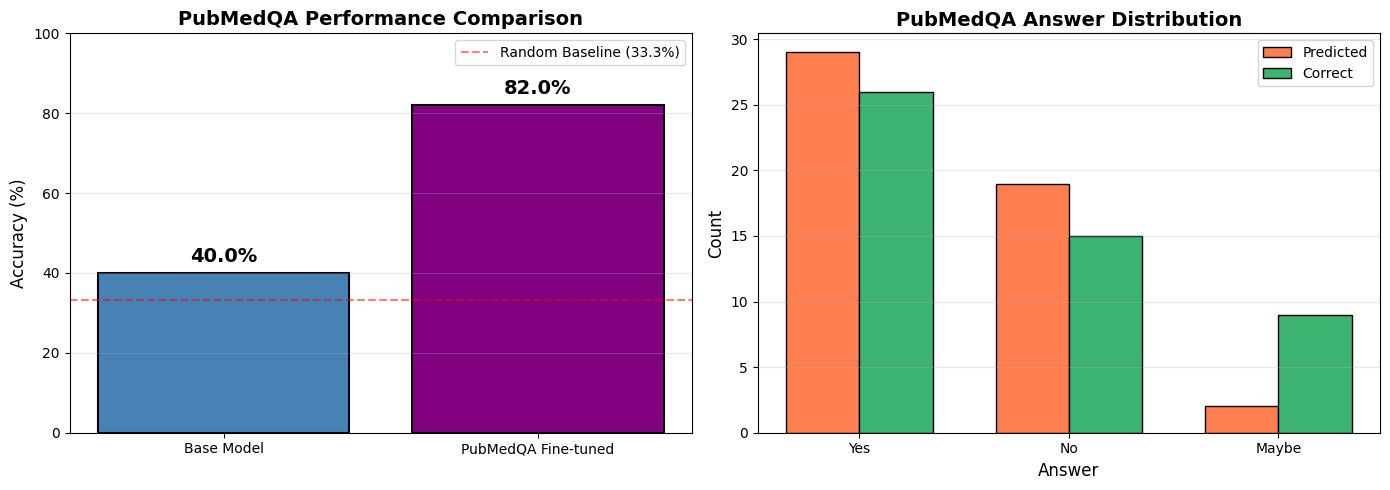

In [ ]:
# PubMedQA Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: PubMedQA Model Comparison
ax1 = axes[0]
models = ['Base Model']
accuracies = [pubmedqa_base_accuracy * 100]
colors = ['steelblue']

if pubmedqa_ft_accuracy is not None:
    models.append('PubMedQA Fine-tuned')
    accuracies.append(pubmedqa_ft_accuracy * 100)
    colors.append('purple')

bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.annotate(f'{acc:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('PubMedQA Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.axhline(y=33.3, color='red', linestyle='--', alpha=0.5, label='Random Baseline (33.3%)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: PubMedQA Answer Distribution
ax2 = axes[1]
results_to_plot = pubmedqa_ft_results if pubmedqa_ft_results is not None else pubmedqa_base_results
answer_counts = results_to_plot['predicted'].value_counts()
correct_counts = results_to_plot['correct_answer'].value_counts()

x = np.arange(3)
width = 0.35

answers = ['yes', 'no', 'maybe']
predicted_vals = [answer_counts.get(a, 0) for a in answers]
correct_vals = [correct_counts.get(a, 0) for a in answers]

ax2.bar(x - width/2, predicted_vals, width, label='Predicted', color='coral', edgecolor='black')
ax2.bar(x + width/2, correct_vals, width, label='Correct', color='mediumseagreen', edgecolor='black')

ax2.set_xlabel('Answer', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('PubMedQA Answer Distribution', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Yes', 'No', 'Maybe'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Saving PubMedQA Evaluation Results

We save the detailed PubMedQA evaluation results to a separate CSV file for further analysis.

In [ ]:
# Save PubMedQA evaluation results
if pubmedqa_ft_results is not None:
    pubmedqa_ft_results.to_csv('pubmedqa_evaluation_results.csv', index=False)
    print("PubMedQA results saved to pubmedqa_evaluation_results.csv")
else:
    pubmedqa_base_results.to_csv('pubmedqa_evaluation_results.csv', index=False)
    print("PubMedQA base model results saved to pubmedqa_evaluation_results.csv")

PubMedQA results saved to pubmedqa_evaluation_results.csv


### Results Summary

Comparing the models:
- **Baseline**: Random guessing = 25% (4 choices)
- **Base Model**: Pre-trained LLM with no medical fine-tuning
- **Fine-Tuned Model**: Our medically-trained model

The improvement shows the value of domain-specific fine-tuning!

## Part 19: Visualization and Analysis

### Performance Visualization

We create two plots:

1. **Model Comparison Bar Chart**:
   - Shows accuracy of base vs fine-tuned model
   - Includes random baseline (25%) for reference
   - Quantifies improvement from fine-tuning

2. **Answer Distribution**:
   - Shows which answers (A, B, C, D) the model predicts
   - Compares to true answer distribution
   - Helps identify any prediction biases

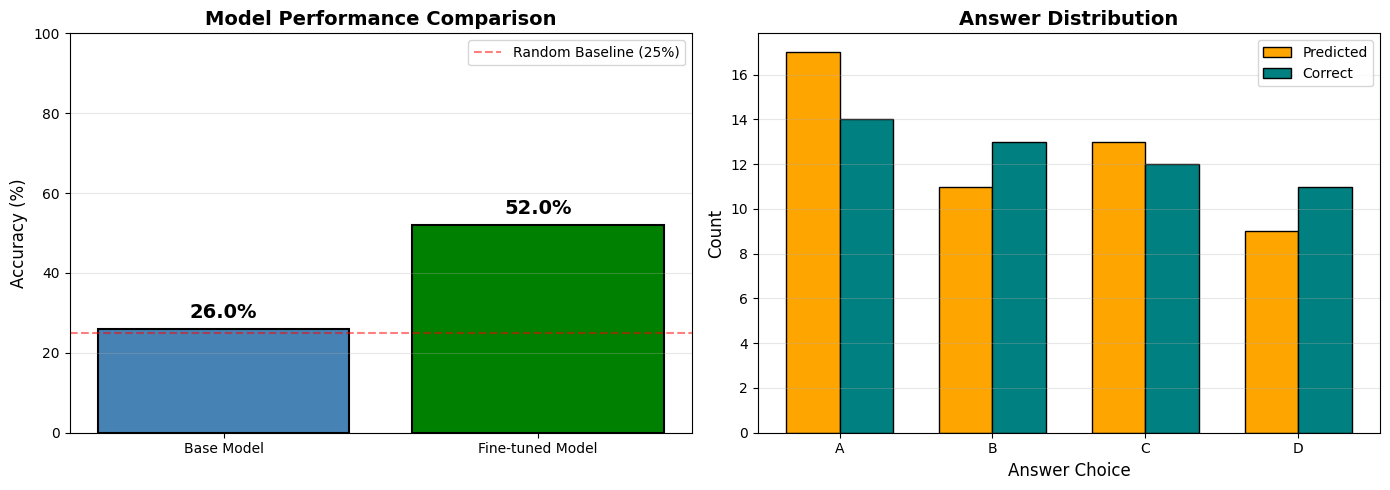

In [ ]:
# Accuracy comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Model Comparison
ax1 = axes[0]
models = ['Base Model']
accuracies = [base_accuracy * 100]
colors = ['steelblue']

if ft_accuracy is not None:
    models.append('Fine-tuned Model')
    accuracies.append(ft_accuracy * 100)
    colors.append('green')

bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.annotate(f'{acc:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Random Baseline (25%)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Answer Distribution
ax2 = axes[1]
results_to_plot = ft_results if ft_results is not None else base_results
answer_counts = results_to_plot['predicted'].value_counts()
correct_counts = results_to_plot['correct_answer'].value_counts()

x = np.arange(4)
width = 0.35

predicted_vals = [answer_counts.get(a, 0) for a in ['A', 'B', 'C', 'D']]
correct_vals = [correct_counts.get(a, 0) for a in ['A', 'B', 'C', 'D']]

ax2.bar(x - width/2, predicted_vals, width, label='Predicted', color='orange', edgecolor='black')
ax2.bar(x + width/2, correct_vals, width, label='Correct', color='teal', edgecolor='black')

ax2.set_xlabel('Answer Choice', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Answer Distribution', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['A', 'B', 'C', 'D'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze performance by medical subject
results_df = ft_results if ft_results is not None else base_results

subject_performance = results_df.groupby('subject').agg({
    'is_correct': ['sum', 'count', 'mean']
}).round(3)

subject_performance.columns = ['Correct', 'Total', 'Accuracy']
subject_performance = subject_performance.sort_values('Accuracy', ascending=False)

print("\nPerformance by Medical Subject:")
print("=" * 50)
print(subject_performance.head(10).to_string())


Performance by Medical Subject:
                          Correct  Total  Accuracy
subject                                           
Pathology                       1      1     1.000
Pharmacology                    3      3     1.000
Radiology                       1      1     1.000
Surgery                         4      5     0.800
Biochemistry                    4      5     0.800
Microbiology                    2      3     0.667
Medicine                        1      2     0.500
ENT                             1      2     0.500
Gynaecology & Obstetrics        2      4     0.500
Physiology                      1      2     0.500


### Performance by Medical Subject

Breaking down accuracy by medical subject helps us:
- Identify which specialties the model handles well
- Find areas needing more training data
- Understand domain-specific strengths/weaknesses

## Part 20: Model Deployment Options

### Merging Adapter into Base Model (Optional)

There are two ways to deploy a LoRA-finetuned model:

**Option 1: Base + Adapter (Recommended)**
- Keep base model and adapter separate
- Smaller files (~10-50MB adapter)
- Same inference speed and memory
- Easy to version control and share

**Option 2: Merged Model**
- Combine adapter into base model
- Single model file (~4-8GB)
- Simpler deployment (no adapter loading)
- Larger storage requirement

For most use cases, Option 1 is better. Only merge if you need a standalone model file.

In [ ]:
# Merging adapters (optional - uncomment to run)
# Note: This requires more memory and may not work on free Colab

MERGE_MODEL = True  # Set to True to merge

if MERGE_MODEL and HAS_FINETUNED:
    print("Merging adapter into base model...")

    # Merge and unload
    merged_model = finetuned_model.merge_and_unload()

    # Save merged model
    MERGED_PATH = "./medical_llm_merged"
    merged_model.save_pretrained(MERGED_PATH)
    tokenizer.save_pretrained(MERGED_PATH)

    print(f"\n Merged model saved to: {MERGED_PATH}")
    !ls -la {MERGED_PATH}
else:
    print("Skipping model merge (set MERGE_MODEL=True to enable)")
    print("\nNote: For deployment, you can either:")
    print("  1. Use base model + adapter (smaller files, same memory at inference)")
    print("  2. Merge into single model (larger files, simpler deployment)")

Merging adapter into base model...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(



 Merged model saved to: ./medical_llm_merged
total 1020476
drwxr-xr-x 2 root root       4096 Jan  5 06:05 .
drwxr-xr-x 1 root root       4096 Jan  5 06:04 ..
-rw-r--r-- 1 root root       1364 Jan  5 06:04 config.json
-rw-r--r-- 1 root root        230 Jan  5 06:04 generation_config.json
-rw-r--r-- 1 root root 1027676612 Jan  5 06:05 model.safetensors
-rw-r--r-- 1 root root        459 Jan  5 06:05 special_tokens_map.json
-rw-r--r-- 1 root root      50646 Jan  5 06:05 tokenizer_config.json
-rw-r--r-- 1 root root   17210019 Jan  5 06:05 tokenizer.json


## Part 23: Saving Results

### Exporting Evaluation Results

Save detailed results to CSV for:
- Further analysis in other tools
- Sharing with team members
- Creating reports and visualizations
- Identifying specific failure cases


In [ ]:
# Save evaluation results
if ft_results is not None:
    ft_results.to_csv('evaluation_results.csv', index=False)
    print("Results saved to evaluation_results.csv")



### Key Takeaways

1. **Parameter-Efficient Fine-Tuning Works**: LoRA achieves good results with <1% trainable parameters
2. **Quantization Enables Training on Limited Hardware**: 4-bit loading fits billion-parameter models on consumer GPUs
3. **Domain-Specific Fine-Tuning Improves Performance**: Medical fine-tuning significantly outperforms base models
4. **Instruction Formatting Matters**: Consistent format (Alpaca/ChatML) helps models learn the task
5. **Task-Specific Adapters**: Training separate adapters for MedMCQA (4-choice MCQ) and PubMedQA (yes/no/maybe) allows specialized performance

### Models Trained

| Dataset | Task Type | Output Directory | Random Baseline |
|---------|-----------|------------------|-----------------|
| MedMCQA | Multiple Choice (A/B/C/D) | `./medical_llm_finetuned/` | 25% |
| PubMedQA | Yes/No/Maybe | `./pubmedqa_llm_finetuned/` | 33.3% |

### Next Steps

- **Increase training**: Run for more epochs with larger datasets
- **Try different models**: Test Llama-3, Mistral, or medical-specific base models
- **Experiment with hyperparameters**: Adjust LoRA rank, learning rate, batch size
- **Add more datasets**: Include MedQA, MMLU-Medical, or other domain-specific data
- **Deploy as API**: Create a web service using FastAPI or similar
- **Fine-tune for specific specialties**: Focus on cardiology, radiology, etc.
- **Multi-task learning**: Combine both datasets for a unified medical QA model

### Resources

- [PEFT Documentation](https://huggingface.co/docs/peft)
- [TRL Documentation](https://huggingface.co/docs/trl)
- [LoRA Paper](https://arxiv.org/abs/2106.09685)
- [MedMCQA Dataset](https://huggingface.co/datasets/openlifescienceai/medmcqa)
- [PubMedQA Dataset](https://huggingface.co/datasets/qiaojin/PubMedQA)